In [1]:
### Import and Install Toools ###

!pip install pandasql
import os
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sqlite3 import connect
from scipy.stats.mstats import winsorize, ks_2samp
from scipy import stats
import seaborn as sns
import pandasql as ps

### Declare Global Variables

conn = connect(':memory:', timeout = 10)
filePath = "/Users/aaron/AaronTuFIMA/PostEarningsAnnouncementDrift"

In [2]:
#Import CRSP CSV
file = filePath + "/CRSPDaily2015To20220331.csv"
columnsToUse = ['TICKER', 'date', 'SHRCD', 'EXCHCD', 'RET']
crsp2015To2022 = pd.read_csv(file, usecols = columnsToUse)[columnsToUse]
print(crsp2015To2022)

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\1249358232.py:4: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp2015To2022 = pd.read_csv(file, usecols = columnsToUse)[columnsToUse]


         TICKER      date  SHRCD  EXCHCD        RET
0          EGAS  20150102   11.0     2.0   0.000000
1          EGAS  20150105   11.0     2.0   0.000000
2          EGAS  20150106   11.0     2.0  -0.010889
3          EGAS  20150107   11.0     2.0   0.001835
4          EGAS  20150108   11.0     2.0   0.005494
...         ...       ...    ...     ...        ...
13967877   TSLA  20220325   11.0     3.0  -0.003235
13967878   TSLA  20220328   11.0     3.0   0.080345
13967879   TSLA  20220329   11.0     3.0    0.00708
13967880   TSLA  20220330   11.0     3.0  -0.005075
13967881   TSLA  20220331   11.0     3.0  -0.014982

[13967882 rows x 5 columns]


In [3]:
#Clean CRSP Data

#Rename colunmns
crsp2015To2022.columns = ['tic', 'date', 'shrcd', 'exchcd', 'ret']

#Convert variables
crsp2015To2022['tic'] = crsp2015To2022['tic'].apply(str)
crsp2015To2022['date'] = pd.to_datetime(crsp2015To2022['date'], format = '%Y%m%d')
crsp2015To2022['shrcd'] = pd.to_numeric(crsp2015To2022['shrcd'], errors = 'coerce')
crsp2015To2022['exchcd'] = pd.to_numeric(crsp2015To2022['exchcd'], errors = 'coerce')
crsp2015To2022['ret'] = pd.to_numeric(crsp2015To2022['ret'], errors = 'coerce')

#Only keep dates after 2019
crsp2019To2022 = crsp2015To2022[crsp2015To2022['date'] >= "2019-01-01"]

#Only keep us based stocks
crsp2019To2022 = crsp2019To2022[(crsp2019To2022['shrcd'] == 10) | (crsp2019To2022['shrcd'] == 11)]

#Only keep NYSE/AMEX exchanges
crsp2019To2022 = crsp2019To2022[(crsp2019To2022['exchcd'] == 1) | (crsp2019To2022['exchcd'] == 11) | (crsp2019To2022['exchcd'] == 2) | (crsp2015To2022['exchcd'] == 12)]

print(crsp2019To2022)

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\2315604083.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  crsp2019To2022 = crsp2019To2022[(crsp2019To2022['exchcd'] == 1) | (crsp2019To2022['exchcd'] == 11) | (crsp2019To2022['exchcd'] == 2) | (crsp2015To2022['exchcd'] == 12)]


           tic       date  shrcd  exchcd       ret
4003      DGSE 2019-01-02   11.0     2.0 -0.043488
4004      DGSE 2019-01-03   11.0     2.0  0.088868
4005      DGSE 2019-01-04   11.0     2.0 -0.060529
4006      DGSE 2019-01-07   11.0     2.0  0.000000
4007      DGSE 2019-01-08   11.0     2.0  0.044444
...        ...        ...    ...     ...       ...
13959300   VPG 2022-03-25   11.0     1.0  0.004617
13959301   VPG 2022-03-28   11.0     1.0 -0.001838
13959302   VPG 2022-03-29   11.0     1.0  0.012891
13959303   VPG 2022-03-30   11.0     1.0 -0.006970
13959304   VPG 2022-03-31   11.0     1.0 -0.018920

[1177820 rows x 5 columns]


In [4]:
#Only keep firms with at least 4 quarters (252 trading days) of data
crsp2019To2022 = crsp2019To2022.groupby('tic').filter(lambda x: len(x) >= 252)

#Sort dataframe
crsp2019To2022 = crsp2019To2022.sort_values(by = ['tic', 'date'], ascending = True)

#Drop missing/infinite values
crsp2019To2022.replace([np.inf, -np.inf], np.nan, inplace = True)
crsp2019To2022 = crsp2019To2022.dropna()

#Reindex
crsp2019To2022 = crsp2019To2022.reset_index()
crsp2019To2022.drop('index', inplace = True, axis = 1)

print(crsp2019To2022)

         tic       date  shrcd  exchcd       ret
0          A 2019-01-02   11.0     1.0 -0.026238
1          A 2019-01-03   11.0     1.0 -0.036840
2          A 2019-01-04   11.0     1.0  0.034614
3          A 2019-01-07   11.0     1.0  0.021234
4          A 2019-01-08   11.0     1.0  0.014660
...      ...        ...    ...     ...       ...
1121427  ZUO 2022-03-25   11.0     1.0 -0.026025
1121428  ZUO 2022-03-28   11.0     1.0  0.008016
1121429  ZUO 2022-03-29   11.0     1.0  0.029158
1121430  ZUO 2022-03-30   11.0     1.0 -0.037347
1121431  ZUO 2022-03-31   11.0     1.0  0.002007

[1121432 rows x 5 columns]


In [5]:
### Import compustat data
file = filePath + "/Compustat2018Through2022.csv"
compustat2018To2022 = pd.read_csv(file)
print(compustat2018To2022)

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\2433682740.py:3: DtypeWarning: Columns (17,18,26,30,647,669,674) have mixed types. Specify dtype option on import or set low_memory=False.
  compustat2018To2022 = pd.read_csv(file)


         gvkey  datadate  fyearq  fqtr  fyr indfmt consol popsrc datafmt  \
0         1004  20180228    2017   3.0    5   INDL      C      D     STD   
1         1004  20180531    2017   4.0    5   INDL      C      D     STD   
2         1004  20180831    2018   1.0    5   INDL      C      D     STD   
3         1004  20181130    2018   2.0    5   INDL      C      D     STD   
4         1004  20190228    2018   3.0    5   INDL      C      D     STD   
...        ...       ...     ...   ...  ...    ...    ...    ...     ...   
190780  351590  20201231    2020   4.0   12   INDL      C      D     STD   
190781  351590  20210331    2021   1.0   12   INDL      C      D     STD   
190782  351590  20210630    2021   2.0   12   INDL      C      D     STD   
190783  351590  20210930    2021   3.0   12   INDL      C      D     STD   
190784  351590  20211231    2021   4.0   12   INDL      C      D     STD   

          tic  ... priusa     sic spcindcd spcseccd  spcsrc  state  stko  \
0         A

In [6]:
### Clean Compustat Daa ###
compustat2018To2022 = compustat2018To2022.filter(['tic', 'datadate', 'fyearq', 'fqtr', 'rdq', 'cshoq', 'prccq'])

#Drop missing / infinite values
compustat2018To2022.replace([np.inf, -np.inf], np.nan, inplace = True)
compustat2018To2022 = compustat2018To2022.dropna()

#Convert Variables
compustat2018To2022['tic'] = compustat2018To2022['tic'].apply(str)
compustat2018To2022['datadate'] = pd.to_datetime(compustat2018To2022['datadate'], format = '%Y%m%d')
compustat2018To2022['fyearq'] = pd.to_numeric(compustat2018To2022['fyearq'], errors = 'coerce')
compustat2018To2022['fqtr'] = pd.to_numeric(compustat2018To2022['fqtr'], errors = 'coerce')
compustat2018To2022['rdq'] = pd.to_datetime(compustat2018To2022['rdq'], format = '%Y%m%d')
compustat2018To2022['cshoq'] = pd.to_numeric(compustat2018To2022['cshoq'], errors = 'coerce')
compustat2018To2022['prccq'] = pd.to_numeric(compustat2018To2022['prccq'], errors = 'coerce')

#Only take dates after 2019
compustat2019To2022 = compustat2018To2022[compustat2018To2022['datadate'] > "2019-01-01"].copy()

#Add market value
compustat2019To2022['market_value'] = compustat2019To2022['cshoq'] * compustat2019To2022['prccq']

#Sort dataframe
compustat2019To2022 = compustat2019To2022.sort_values(by = ['tic', 'datadate'], ascending = True)

#Drop missing / infinite values
compustat2019To2022.replace([np.inf, -np.inf], np.nan, inplace = True)
compustat2019To2022 = compustat2019To2022.dropna()

#Drop unneeded columns
compustat2019To2022.drop('cshoq', inplace = True, axis = 1)
compustat2019To2022.drop('prccq', inplace = True, axis = 1)

#Reindex
compustat2019To2022 = compustat2019To2022.reset_index()
compustat2019To2022.drop('index', inplace = True, axis = 1)

print(compustat2019To2022)

         tic   datadate  fyearq  fqtr        rdq  market_value
0          A 2019-01-31    2019   1.0 2019-02-20  24183.900000
1          A 2019-04-30    2019   2.0 2019-05-14  24883.793500
2          A 2019-07-31    2019   3.0 2019-08-14  21489.127770
3          A 2019-10-31    2019   4.0 2019-11-25  23412.128250
4          A 2020-01-31    2020   1.0 2020-02-18  25597.562880
...      ...        ...     ...   ...        ...           ...
86142  ZZZOF 2020-11-30    2020   3.0 2021-01-27      1.939570
86143  ZZZOF 2021-02-28    2020   4.0 2021-06-30      4.848925
86144  ZZZOF 2021-05-31    2021   1.0 2021-07-29      2.134000
86145  ZZZOF 2021-08-31    2021   2.0 2021-10-27      1.358000
86146  ZZZOF 2021-11-30    2021   3.0 2022-01-27      1.008800

[86147 rows x 6 columns]


In [7]:
#Merge Compustat and CRSP Dataframes

#left join dataframes
crsp2019To2022.to_sql("crsp2019To2022", conn, if_exists = 'replace')
compustat2019To2022.to_sql("compustat2019To2022", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT crsp2019To2022.tic, crsp2019To2022.date, crsp2019To2022.ret,
                        compustat2019To2022.datadate, compustat2019To2022.rdq, compustat2019To2022.market_value
        FROM crsp2019To2022
        LEFT JOIN compustat2019To2022
        ON crsp2019To2022.tic = compustat2019To2022.tic
        AND crsp2019To2022.date = compustat2019To2022.rdq
        '''

mainDF = pd.read_sql(query, conn)

#Add calendar year column
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['year'] = mainDF['date'].dt.year

#Add calendar quarter column
mainDF['qtr'] = np.ceil(mainDF['date'].dt.month / 3)

print(mainDF)

         tic       date       ret datadate   rdq  market_value  year  qtr
0          A 2019-01-02 -0.026238     None  None           NaN  2019  1.0
1          A 2019-01-03 -0.036840     None  None           NaN  2019  1.0
2          A 2019-01-04  0.034614     None  None           NaN  2019  1.0
3          A 2019-01-07  0.021234     None  None           NaN  2019  1.0
4          A 2019-01-08  0.014660     None  None           NaN  2019  1.0
...      ...        ...       ...      ...   ...           ...   ...  ...
1121284  ZUO 2022-03-25 -0.026025     None  None           NaN  2022  1.0
1121285  ZUO 2022-03-28  0.008016     None  None           NaN  2022  1.0
1121286  ZUO 2022-03-29  0.029158     None  None           NaN  2022  1.0
1121287  ZUO 2022-03-30 -0.037347     None  None           NaN  2022  1.0
1121288  ZUO 2022-03-31  0.002007     None  None           NaN  2022  1.0

[1121289 rows x 8 columns]


In [8]:
#Add size deciles

#Create new dataframe with only rdq data
dataOnRDQ = mainDF.dropna()

#Take final market value of each year for each firm
marketValueYearStart = dataOnRDQ.groupby(['year', 'tic'], as_index = False)['market_value'].first() #now dataframe with only first value of each year

#Add quantile of each firm baed on market value
marketValueYearStart['size_quantile'] = marketValueYearStart.groupby(['year'])['market_value'].rank(pct = True)

#Convert quantities to deciles
marketValueYearStart['size_decile'] = np.ceil(marketValueYearStart['size_quantile'] * 10)

#Merge size deciles back into main dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
marketValueYearStart.to_sql("marketValueYearStart", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.tic, mainDF.date, mainDF.datadate, mainDF.year, mainDf.qtr,
                mainDF.ret, mainDF.rdq, marketValueYearStart.size_decile
        FROM mainDF
        LEFT JOIN marketValueYearStart
        ON mainDF.tic = marketValueYearStart.tic
        AND mainDF.year = marketValueYearStart.year
        '''
mainDF = pd.read_sql(query, conn)

print(mainDF)

         tic                 date datadate  year  qtr       ret   rdq  \
0          A  2019-01-02 00:00:00     None  2019  1.0 -0.026238  None   
1          A  2019-01-03 00:00:00     None  2019  1.0 -0.036840  None   
2          A  2019-01-04 00:00:00     None  2019  1.0  0.034614  None   
3          A  2019-01-07 00:00:00     None  2019  1.0  0.021234  None   
4          A  2019-01-08 00:00:00     None  2019  1.0  0.014660  None   
...      ...                  ...      ...   ...  ...       ...   ...   
1121283  ZUO  2022-03-25 00:00:00     None  2022  1.0 -0.026025  None   
1121284  ZUO  2022-03-28 00:00:00     None  2022  1.0  0.008016  None   
1121285  ZUO  2022-03-29 00:00:00     None  2022  1.0  0.029158  None   
1121286  ZUO  2022-03-30 00:00:00     None  2022  1.0 -0.037347  None   
1121287  ZUO  2022-03-31 00:00:00     None  2022  1.0  0.002007  None   

         size_decile  
0                9.0  
1                9.0  
2                9.0  
3                9.0  
4       

In [9]:
# Calculate Abnormal returns

#Calculate mean return for that data for all firms with same size decile
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['size_decile'] = pd.to_numeric(mainDF['size_decile'], errors = 'coerce')

#New dataframe with average return of every trading day for the 10 size deciles
avgRet = mainDF.groupby(['date', 'size_decile'], as_index = False).apply(lambda x: np.average(x['ret']))
avgRet.columns = ['date', 'size_decile', 'avg_ret'] #name new column as avg_ret

#Merge average returns back into main dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
avgRet.to_sql("avgRet", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, avgRet.avg_ret
        FROM mainDF
        LEFT JOIN avgRet
        ON mainDF.date = avgRet.date
        AND mainDF.size_Decile = avgRet.size_decile
        '''
mainDF = pd.read_sql(query, conn)
mainDF.drop('index', inplace = True, axis = 1)

#Calculate abnormal returns
mainDF['ret'] = pd.to_numeric(mainDF['ret'], errors = 'coerce')
mainDF['avg_ret'] = pd.to_numeric(mainDF['avg_ret'], errors = 'coerce')
mainDF['abm_ret'] = mainDF['ret'] - mainDF['avg_ret']

print(mainDF)

         tic                 date datadate  year  qtr       ret   rdq  \
0          A  2019-01-02 00:00:00     None  2019  1.0 -0.026238  None   
1          A  2019-01-03 00:00:00     None  2019  1.0 -0.036840  None   
2          A  2019-01-04 00:00:00     None  2019  1.0  0.034614  None   
3          A  2019-01-07 00:00:00     None  2019  1.0  0.021234  None   
4          A  2019-01-08 00:00:00     None  2019  1.0  0.014660  None   
...      ...                  ...      ...   ...  ...       ...   ...   
1121283  ZUO  2022-03-25 00:00:00     None  2022  1.0 -0.026025  None   
1121284  ZUO  2022-03-28 00:00:00     None  2022  1.0  0.008016  None   
1121285  ZUO  2022-03-29 00:00:00     None  2022  1.0  0.029158  None   
1121286  ZUO  2022-03-30 00:00:00     None  2022  1.0 -0.037347  None   
1121287  ZUO  2022-03-31 00:00:00     None  2022  1.0  0.002007  None   

         size_decile   avg_ret   abm_ret  
0                9.0 -0.001194 -0.025044  
1                9.0 -0.015902 -0.020

In [10]:
#Import IBES data
file = filePath + "/IBESSurpriseHistory.csv"
ibesHistory = pd.read_csv(file)
print(ibesHistory)

        TICKER OFTIC MEASURE FISCALP  PYEAR  PMON  USFIRM   anndats   actual  \
0         0000  TLMR     EPS     QTR   2014     3       1  20140506    0.120   
1         0000  TLMR     EPS     QTR   2014     6       1  20140806    0.270   
2         0000  TLMR     EPS     QTR   2014     9       1  20141104    0.260   
3         0000  TLMR     EPS     ANN   2014    12       1  20150130    1.210   
4         0000  TLMR     EPS     QTR   2014    12       1  20150130    0.160   
...        ...   ...     ...     ...    ...   ...     ...       ...      ...   
1423206   ZYNX  ZYXI     SAL     QTR   2021     3       1  20210429   24.127   
1423207   ZYNX  ZYXI     SAL     QTR   2021     6       1  20210729   31.022   
1423208   ZYNX  ZYXI     SAL     QTR   2021     9       1  20211102   34.786   
1423209   ZYNX  ZYXI     SAL     ANN   2021    12       1  20220224  130.301   
1423210   ZYNX  ZYXI     SAL     QTR   2021    12       1  20220224   40.366   

          surpmean  surpstdev  suescore

In [11]:
#Clean IBES Data

#Only keep data after 2019
ibesHistory['PYEAR'] = pd.to_numeric(ibesHistory['PYEAR'], errors = 'coerce')
ibesHistory['PMON'] = pd.to_numeric(ibesHistory['PMON'], errors = 'coerce')
ibes2019To2022 = ibesHistory[ibesHistory['PYEAR'] >= 2019]

#only keep quarterly data
ibes2019To2022 = ibes2019To2022[ibes2019To2022['FISCALP'] == "QTR"]

#only keep earnings per share (eps) date
ibes2019To2022 = ibes2019To2022[ibes2019To2022['MEASURE'] == "EPS"]

#Reindex
ibes2019To2022 = ibes2019To2022.reset_index()
ibes2019To2022.drop('index', inplace = True, axis = 1)

#Add datadate of each row (last day of that month)
ibes2019To2022['PDAY'] = 1
ibes2019To2022['datadate'] = pd.to_datetime((10000 * ibes2019To2022['PYEAR'] + 100 * ibes2019To2022['PMON'] + ibes2019To2022['PDAY']).apply(str), format = '%Y%m%d')
ibes2019To2022['datadate'] = pd.to_datetime((10000 * ibes2019To2022['PYEAR'] + 100 * ibes2019To2022['PMON'] + ibes2019To2022['datadate'].dt.days_in_month).apply(str), format = '%Y%m%d')

#parse relevant columns
ibes2019To2022 = ibes2019To2022.filter(['OFTIC', 'PYEAR', 'PMON', 'suescore', 'datadate'])
ibes2019To2022.columns = ['tic', 'year', 'month', 'sue', 'datadate']

#Drop missing and infinite
ibes2019To2022.replace([np.inf, -np.inf], np.nan, inplace = True)
ibes2019To2022 = ibes2019To2022.dropna()

#Sort dataframe
ibes2019To2022 = ibes2019To2022.sort_values(by = ['tic', 'datadate'], ascending = True)

#reindex
ibes2019To2022 = ibes2019To2022.reset_index()
ibes2019To2022.drop('index', inplace = True, axis = 1)

print(ibes2019To2022)


        tic  year  month      sue   datadate
0         A  2019      1  2.91543 2019-01-31
1         A  2019      4 -0.61391 2019-04-30
2         A  2019      7  4.67368 2019-07-31
3         A  2019     10  4.55811 2019-10-31
4         A  2020      1  0.07880 2020-01-31
...     ...   ...    ...      ...        ...
43374  ZYXI  2020     12 -0.68286 2020-12-31
43375  ZYXI  2021      3  0.44723 2021-03-31
43376  ZYXI  2021      6  1.56530 2021-06-30
43377  ZYXI  2021      9  1.55065 2021-09-30
43378  ZYXI  2021     12  1.48519 2021-12-31

[43379 rows x 5 columns]


In [12]:
#Merge sue back in to the main dataframe

#Left join IBES data into main dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
ibes2019To2022.to_sql("ibes2019To2022", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, ibes2019To2022.sue
        FROM mainDF
        LEFT JOIN ibes2019To2022
        ON mainDF.tic = ibes2019To2022.tic
        AND mainDf.datadate = ibes2019To2022.datadate
        '''
mainDF = pd.read_sql(query, conn)
mainDF.drop('index', inplace = True, axis = 1)

print(mainDF)

         tic                 date datadate  year  qtr       ret   rdq  \
0          A  2019-01-02 00:00:00     None  2019  1.0 -0.026238  None   
1          A  2019-01-03 00:00:00     None  2019  1.0 -0.036840  None   
2          A  2019-01-04 00:00:00     None  2019  1.0  0.034614  None   
3          A  2019-01-07 00:00:00     None  2019  1.0  0.021234  None   
4          A  2019-01-08 00:00:00     None  2019  1.0  0.014660  None   
...      ...                  ...      ...   ...  ...       ...   ...   
1121283  ZUO  2022-03-25 00:00:00     None  2022  1.0 -0.026025  None   
1121284  ZUO  2022-03-28 00:00:00     None  2022  1.0  0.008016  None   
1121285  ZUO  2022-03-29 00:00:00     None  2022  1.0  0.029158  None   
1121286  ZUO  2022-03-30 00:00:00     None  2022  1.0 -0.037347  None   
1121287  ZUO  2022-03-31 00:00:00     None  2022  1.0  0.002007  None   

         size_decile   avg_ret   abm_ret  sue  
0                9.0 -0.001194 -0.025044  NaN  
1                9.0 -0.015

In [13]:
#Add SUE Deciles

#Filter for only data on rdq
dataOnRDQ = mainDF.dropna()

#Take unique yeaer and quarter to decrease runtime
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT year, qtr
        FROM dataOnRDQ
        '''
sueDeciles = pd.read_sql(query, conn)

#Generate new dataframe with quantiles of each quarter
for i in range(1,10):
    currentDecile = dataOnRDQ.groupby(['year', 'qtr'])['sue'].quantile(i / 10)
    sueDeciles['prior_quarter_sue_decile' + str(i)] = "asdf"
    for j in sueDeciles.index:
        sueDeciles.loc[j, 'prior_quarter_sue_decile' + str(i)] = currentDecile[sueDeciles.loc[j, 'year'], sueDeciles.loc[j, 'qtr']]
    sueDeciles['prior_quarter_sue_decile' + str(i)] = sueDeciles['prior_quarter_sue_decile' + str(i)].shift(1)
    sueDeciles['prior_quarter_sue_decile' + str(i)] = pd.to_numeric(sueDeciles['prior_quarter_sue_decile' + str(i)], errors = 'coerce')
    

In [14]:
#Merge SUE quantiles back into
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
sueDeciles.to_sql("sueDeciles", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT dataOnRDQ.*, sueDeciles.prior_quarter_sue_decile1, sueDeciles.prior_quarter_sue_decile2, sueDeciles.prior_quarter_sue_decile3,
                sueDeciles.prior_quarter_sue_decile4, sueDeciles.prior_quarter_sue_decile5, sueDeciles.prior_quarter_sue_decile6, 
                sueDeciles.prior_quarter_sue_decile7, sueDeciles.prior_quarter_sue_decile8, sueDeciles.prior_quarter_sue_decile9
        FROM dataOnRDQ
        LEFT JOIN sueDeciles
        ON dataOnRDQ.year = sueDeciles.year
        AND dataOnRDQ.qtr = sueDeciles.qtr
        '''
dataOnRDQ = pd.read_sql(query, conn)

#Drop index columns
dataOnRDQ.drop('index', inplace = True, axis = 1)

#Drop first quarter data of every firm (null SUE prior quarter)
dataOnRDQ = dataOnRDQ.dropna()

#Drop 2nd quarter of overall data (2019Q2 due to unsufficient sample size in 2019Q1 to rank SUE)
dataOnRDQ = dataOnRDQ[(dataOnRDQ['year'] != 2019) | (dataOnRDQ['qtr'] != 2)]

#Reindex
dataOnRDQ = dataOnRDQ.reset_index()
dataOnRDQ.drop('index', inplace = True, axis = 1)

In [15]:
#Add sue decile to every row
dataOnRDQ['sue_decile'] = ""
dataOnRDQ['sue'] = pd.to_numeric(dataOnRDQ['sue'], errors = 'coerce')
for i in dataOnRDQ.index:
    if dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile1']:
        dataOnRDQ.loc[i, 'sue_decile'] = 1
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile2']:
        dataOnRDQ.loc[i, 'sue_decile'] = 2
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile3']:
        dataOnRDQ.loc[i, 'sue_decile'] = 3
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile4']:
        dataOnRDQ.loc[i, 'sue_decile'] = 4
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile5']:
        dataOnRDQ.loc[i, 'sue_decile'] = 5
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile6']:
        dataOnRDQ.loc[i, 'sue_decile'] = 6
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile7']:
        dataOnRDQ.loc[i, 'sue_decile'] = 7
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile8']:
        dataOnRDQ.loc[i, 'sue_decile'] = 8
    elif dataOnRDQ.loc[i, 'sue'] <= dataOnRDQ.loc[i, 'prior_quarter_sue_decile9']:
        dataOnRDQ.loc[i, 'sue_decile'] = 9
    else:
        dataOnRDQ.loc[i, 'sue_decile'] = 10

#Drop decile values
toDrop = []
for i in range(1, 10):
    toDrop.append('prior_quarter_sue_decile' + str(i))
dataOnRDQ.drop(toDrop, inplace = True, axis = 1)

In [16]:
#Merge SUE Decile data with Main Dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, dataOnRDQ.sue_decile
        FROM mainDF
        LEFT JOIN dataOnRDQ
        ON mainDF.tic = dataOnRDQ.tic
        AND mainDF.year = dataOnRDQ.year
        AND mainDF.qtr = dataOnRDQ.qtr
        '''
mainDF = pd.read_sql(query, conn)

#Drop index columns
mainDF.drop('index', inplace = True, axis = 1)

#Convert variables
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['datadate'] = pd.to_datetime(mainDF['datadate'], errors = 'coerce')
mainDF['rdq'] = pd.to_datetime(mainDF['rdq'], errors = 'coerce')
mainDF['tic'] = mainDF['tic'].apply(str)

#Only keep one of data per tic and date (no duplicates)
mainDF = mainDF.groupby(['tic', 'date'], as_index = False)
mainDF = mainDF.first()

print(mainDF)

         tic       date datadate  year  qtr       ret rdq  size_decile  \
0          A 2019-01-02      NaT  2019  1.0 -0.026238 NaT          9.0   
1          A 2019-01-03      NaT  2019  1.0 -0.036840 NaT          9.0   
2          A 2019-01-04      NaT  2019  1.0  0.034614 NaT          9.0   
3          A 2019-01-07      NaT  2019  1.0  0.021234 NaT          9.0   
4          A 2019-01-08      NaT  2019  1.0  0.014660 NaT          9.0   
...      ...        ...      ...   ...  ...       ...  ..          ...   
1107138  ZUO 2022-03-25      NaT  2022  1.0 -0.026025 NaT          4.0   
1107139  ZUO 2022-03-28      NaT  2022  1.0  0.008016 NaT          4.0   
1107140  ZUO 2022-03-29      NaT  2022  1.0  0.029158 NaT          4.0   
1107141  ZUO 2022-03-30      NaT  2022  1.0 -0.037347 NaT          4.0   
1107142  ZUO 2022-03-31      NaT  2022  1.0  0.002007 NaT          4.0   

          avg_ret   abm_ret  sue  sue_decile  
0       -0.001194 -0.025044  NaN         NaN  
1       -0.015902

In [17]:
### ALl firms: calculate cumulative abnormal returns for every RDQ ###

#Store mainDF for future uses
temp = mainDF.copy()
originalMain = mainDF
mainDF = temp

#Generate new dataframe with tic, sue decile, and size decile on rdq
TicOfRDQ = mainDF.dropna()
TicOfRDQ = TicOfRDQ.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRet = mainDF.reset_index()
abnRet.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRet = abnRet.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRet['new_index'] = abnRet['tic'].apply(str) + "/" + abnRet['original_index'].apply(str)
abnRet = abnRet.set_index('new_index')

#create new array to store CAR around RDQ
carArrayBeforeAll = []
carArrayAfterAll = []
for i in range(11):
    carArrayBeforeAll.append([])
    carArrayAfterAll.append([])
    
#calculate Car and store them in corresponding SUE deciles
n = 60 #set to number of days before/after rdq to be analyzed

for rdqDate in TicOfRDQ.index:
    #Generate indicies for abnormal return dataframe
    nDaysBeforeIndex = str(TicOfRDQ.loc[rdqDate, 'tic']) + "/" + str(rdqDate - n)
    rdqDateIndex = str(TicOfRDQ.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQ.loc[rdqDate, 'tic']) + "/" + str(rdqDate + n)
    if (nDaysBeforeIndex in abnRet.index) and (nDaysAfterIndex in abnRet.index):
        #Add n days before CAR
        beforeDF = pd.DataFrame(abnRet.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
        beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF.loc[0, 'abn_ret']
        carArrayBeforeAll[TicOfRDQ.loc[rdqDate, 'sue_decile'].astype(int)].append(beforeDF['car'])
        #Add n days after CAR
        afterDF = pd.DataFrame(abnRet.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF.loc[0, 'abn_ret']
        carArrayAfterAll[TicOfRDQ.loc[rdqDate, 'sue_decile'].astype(int)].append(afterDF['car'])

In [18]:
### ALL FIRMS: generate new car arrays for each decile and each day

#Create new array to store car data on each day before RDQ
carAllByDaysBefore = []
#Set up empty array
for i in range(11):
    carAllByDaysBefore.append([])
    for j in range(61):
        carAllByDaysBefore[i].append([])

#Add Car data
for i in range(len(carArrayBeforeAll)):
    for j in range(len(carArrayBeforeAll[i])):
        for k in range(len(carAllByDaysBefore[i])):
            carAllByDaysBefore[i][k].append(carArrayBeforeAll[i][j][k])
            
#Create new array to store car data on each day after RDQ
carAllByDaysAfter = []
#Set up empty array
for i in range(11):
    carAllByDaysAfter.append([])
    for j in range(61):
        carAllByDaysAfter[i].append([])
        
#Add Car data
for i in range(len(carArrayAfterAll)):
    for j in range(len(carArrayAfterAll[i])):
        for k in range(len(carAllByDaysAfter[i])):
            carAllByDaysAfter[i][k].append(carArrayAfterAll[i][j][k])

In [19]:
#new dataframe to store data
avgCARAllBefore = pd.DataFrame()
for i in range(1,11):
    avgCARAllBefore['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysBefore[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARAllBefore = avgCARAllBefore.reset_index()
avgCARAllBefore = avgCARAllBefore.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARAllBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARAllBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARAllBefore['days_relative_to_rdq'] -= 60

print(avgCARAllBefore)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60  0.000000  0.000000  0.000000  0.000000  0.000000   
1                    -59 -0.032265  0.041331  0.109014 -0.012663  0.105149   
2                    -58 -0.081745 -0.045392 -0.061688 -0.058010  0.222701   
3                    -57 -0.160471  0.125799 -0.203450 -0.045370  0.256293   
4                    -56 -0.318694  0.163423 -0.257944 -0.083663  0.263284   
..                   ...       ...       ...       ...       ...       ...   
56                    -4 -1.568051 -1.249724 -1.686392 -1.527070  0.894858   
57                    -3 -1.750371 -1.488610 -1.875527 -1.631404  1.033913   
58                    -2 -1.769042 -1.411614 -2.157912 -1.554892  1.049473   
59                    -1 -1.715537 -1.486227 -2.013908 -1.574204  1.156539   
60                     0 -3.695478 -2.670704 -3.079963 -1.674057  1.626211   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

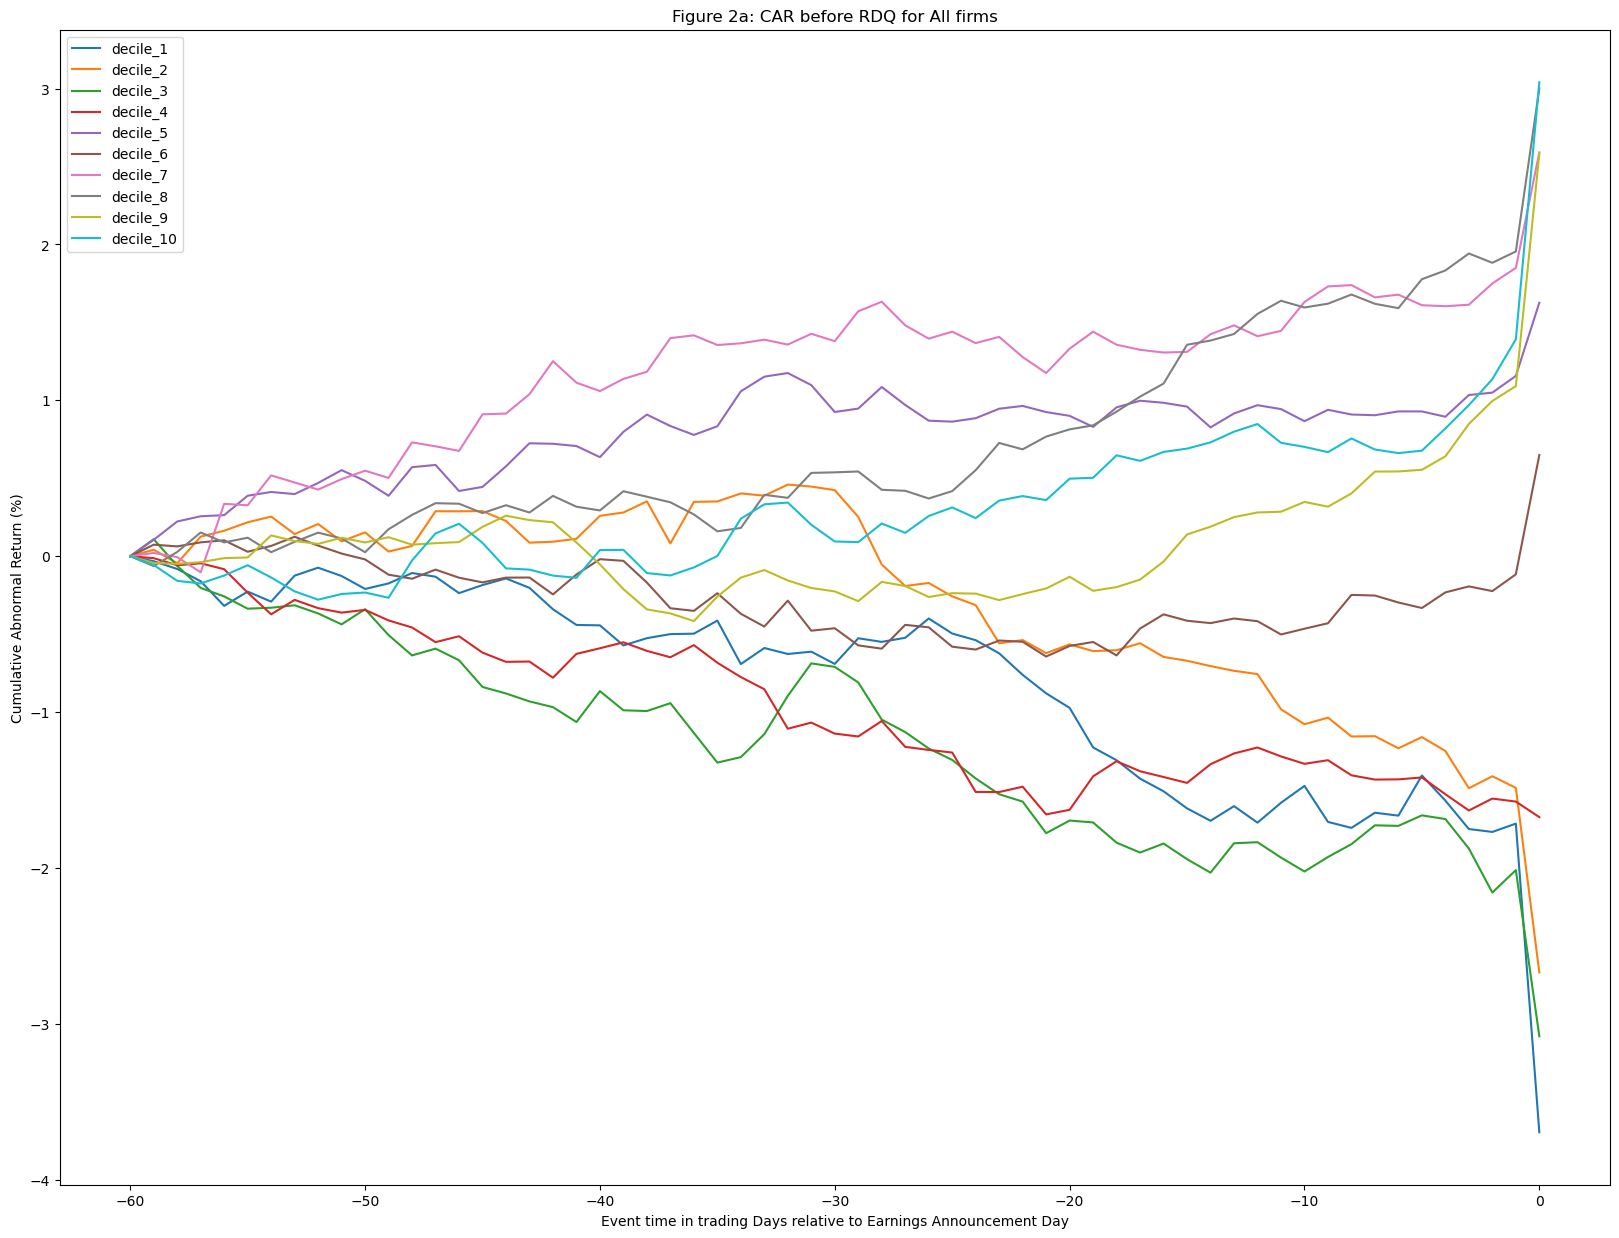

In [20]:
#Plot graph in python
allFirmsBeforeRDQ = avgCARAllBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR before RDQ for All firms")
allFirmsBeforeRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
allFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = allFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/allFirmsBeforeRDQ.png")

In [21]:
#new dataframe to store data
avgCARAllAfter = pd.DataFrame()
for i in range(1,11):
    avgCARAllAfter['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysAfter[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARAllAfter = avgCARAllAfter.reset_index()
avgCARAllAfter = avgCARAllAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [0, 60] since data is before RDQ
avgCARAllAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARAllAfter['days_relative_to_rdq'], errors = 'coerce')

print(avgCARAllAfter)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.183261 -1.430634 -1.058123  0.048887  0.060333   
2                      2 -2.200740 -1.445782 -1.176919  0.027433  0.026823   
3                      3 -2.058723 -1.447307 -1.347030  0.062261 -0.005762   
4                      4 -2.029053 -1.440709 -1.454460  0.066210 -0.122970   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -2.242126 -1.418102 -0.388293  0.234788  0.788499   
57                    57 -2.477896 -1.307799 -0.391807  0.380279  0.895517   
58                    58 -2.015005 -1.327772 -0.492062  0.504289  0.941042   
59                    59 -2.137091 -1.150389 -0.461763  0.421818  0.951362   
60                    60 -1.994887 -1.054348 -0.561888  0.340590  0.945902   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

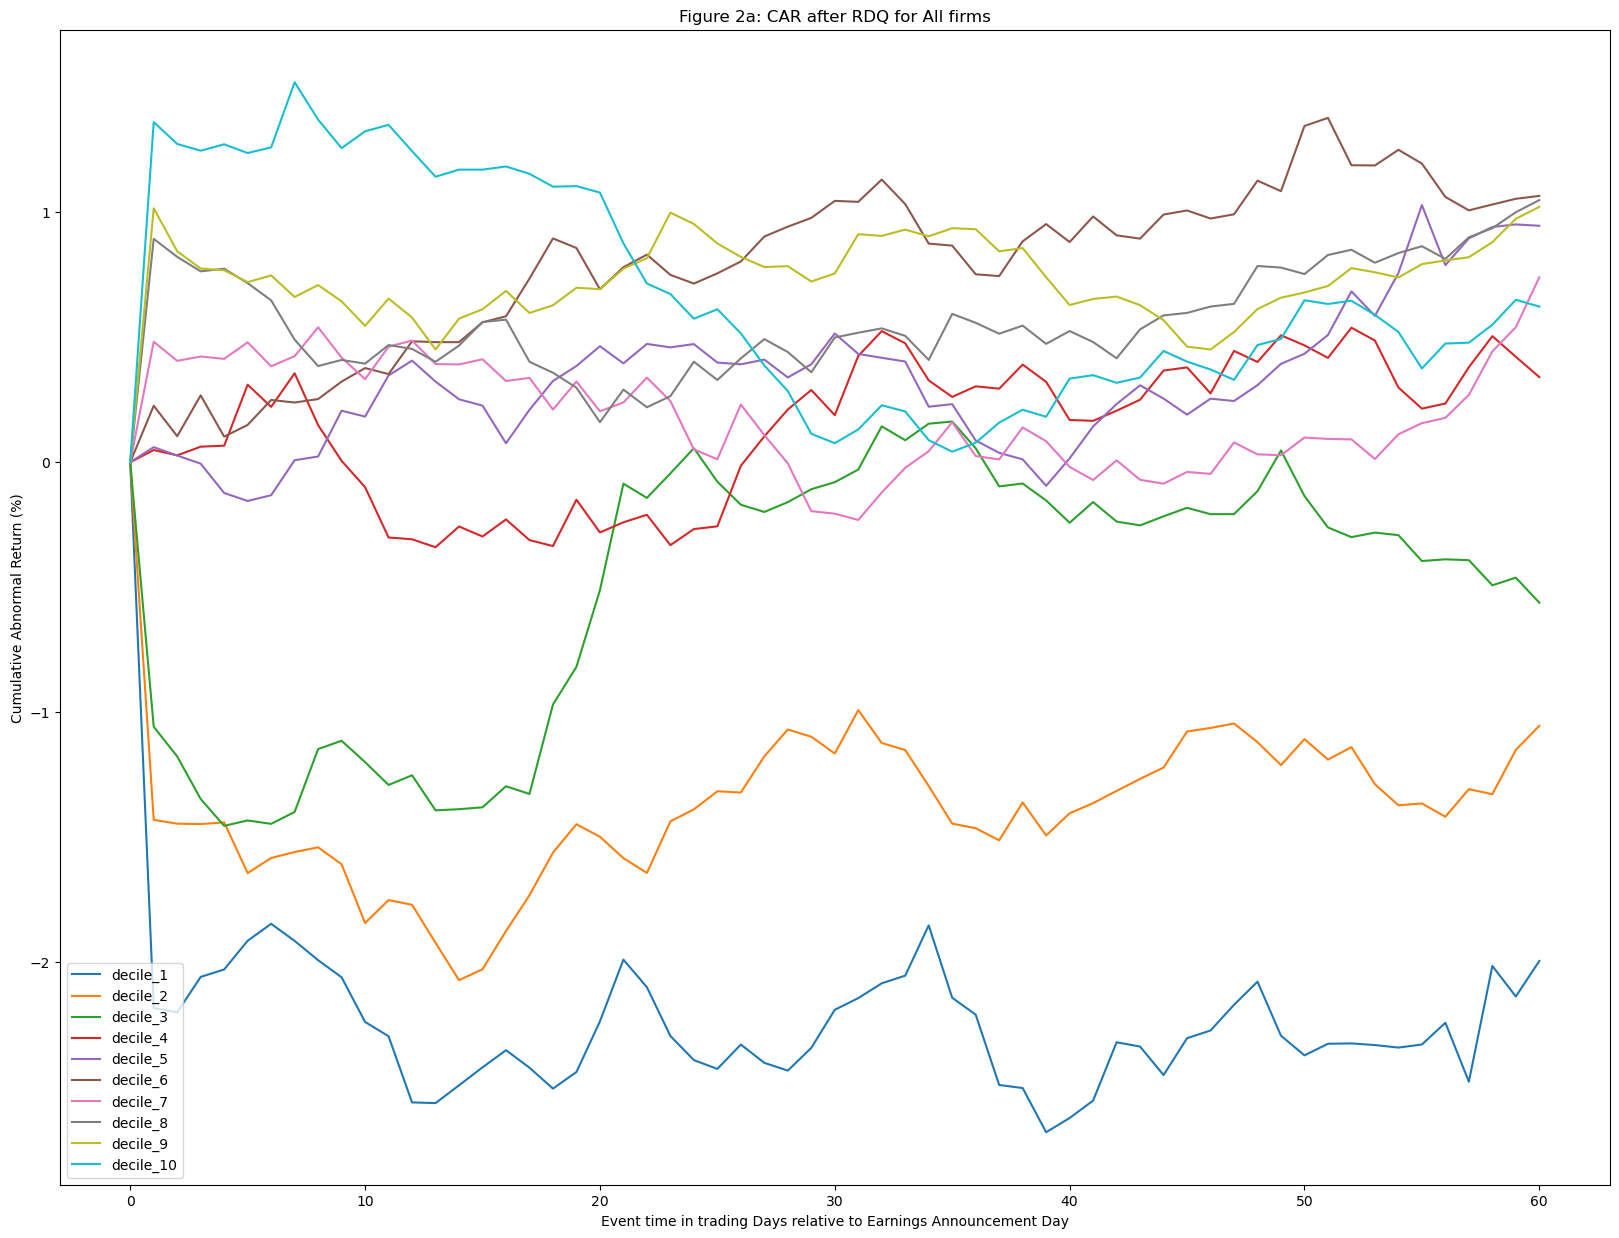

In [22]:
#Plot after graph in python
allFirmsAfterRDQ = avgCARAllAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR after RDQ for All firms")
allFirmsAfterRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
allFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = allFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/allFirmsAfterRDQ.png")

In [23]:
###Big firms: Calculate CAR for every RDQ

mainDF = originalMain

#Only keep big firms
mainDF = mainDF[mainDF['size_decile'] >= 8]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)

#Generate new dataframe with tic, sue decile, and size decile on rdq
TicOfRDQBig = mainDF.dropna()
TicOfRDQBig = TicOfRDQBig.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetBig = mainDF.reset_index()
abnRetBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetBig = abnRetBig.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetBig['new_index'] = abnRetBig['tic'].apply(str) + "/" + abnRetBig['original_index'].apply(str)
abnRetBig = abnRetBig.set_index('new_index')

#create new array to store CAR around RDQ
carArrayBeforeBig = []
carArrayAfterBig = []
for i in range(11):
    carArrayBeforeBig.append([])
    carArrayAfterBig.append([])
    
#calculate Car and store them in corresponding SUE deciles
n = 60 #set to number of days before/after rdq to be analyzed

for rdqDate in TicOfRDQBig.index:
    #Generate indicies for abnormal return dataframe
    nDaysBeforeIndex = str(TicOfRDQBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate - n)
    rdqDateIndex = str(TicOfRDQBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate + n)
    if (nDaysBeforeIndex in abnRetBig.index) and (nDaysAfterIndex in abnRetBig.index):
        #Add n days before CAR
        beforeDF = pd.DataFrame(abnRetBig.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
        beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF.loc[0, 'abn_ret']
        carArrayBeforeBig[TicOfRDQBig.loc[rdqDate, 'sue_decile'].astype(int)].append(beforeDF['car'])
        #Add n days after CAR
        afterDF = pd.DataFrame(abnRetBig.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF.loc[0, 'abn_ret']
        carArrayAfterBig[TicOfRDQBig.loc[rdqDate, 'sue_decile'].astype(int)].append(afterDF['car'])

In [24]:
### Big FIRMS: generate new car arrays for each decile and each day

#Create new array to store car data on each day before RDQ
carBigByDaysBefore = []
#Set up empty array
for i in range(11):
    carBigByDaysBefore.append([])
    for j in range(61):
        carBigByDaysBefore[i].append([])

#Add Car data
for i in range(len(carArrayBeforeBig)):
    for j in range(len(carArrayBeforeBig[i])):
        for k in range(len(carBigByDaysBefore[i])):
            carBigByDaysBefore[i][k].append(carArrayBeforeBig[i][j][k])
            
#Create new array to store car data on each day after RDQ
carBigByDaysAfter = []
#Set up empty array
for i in range(11):
    carBigByDaysAfter.append([])
    for j in range(61):
        carBigByDaysAfter[i].append([])
        
#Add Car data
for i in range(len(carArrayAfterBig)):
    for j in range(len(carArrayAfterBig[i])):
        for k in range(len(carBigByDaysAfter[i])):
            carBigByDaysAfter[i][k].append(carArrayAfterBig[i][j][k])

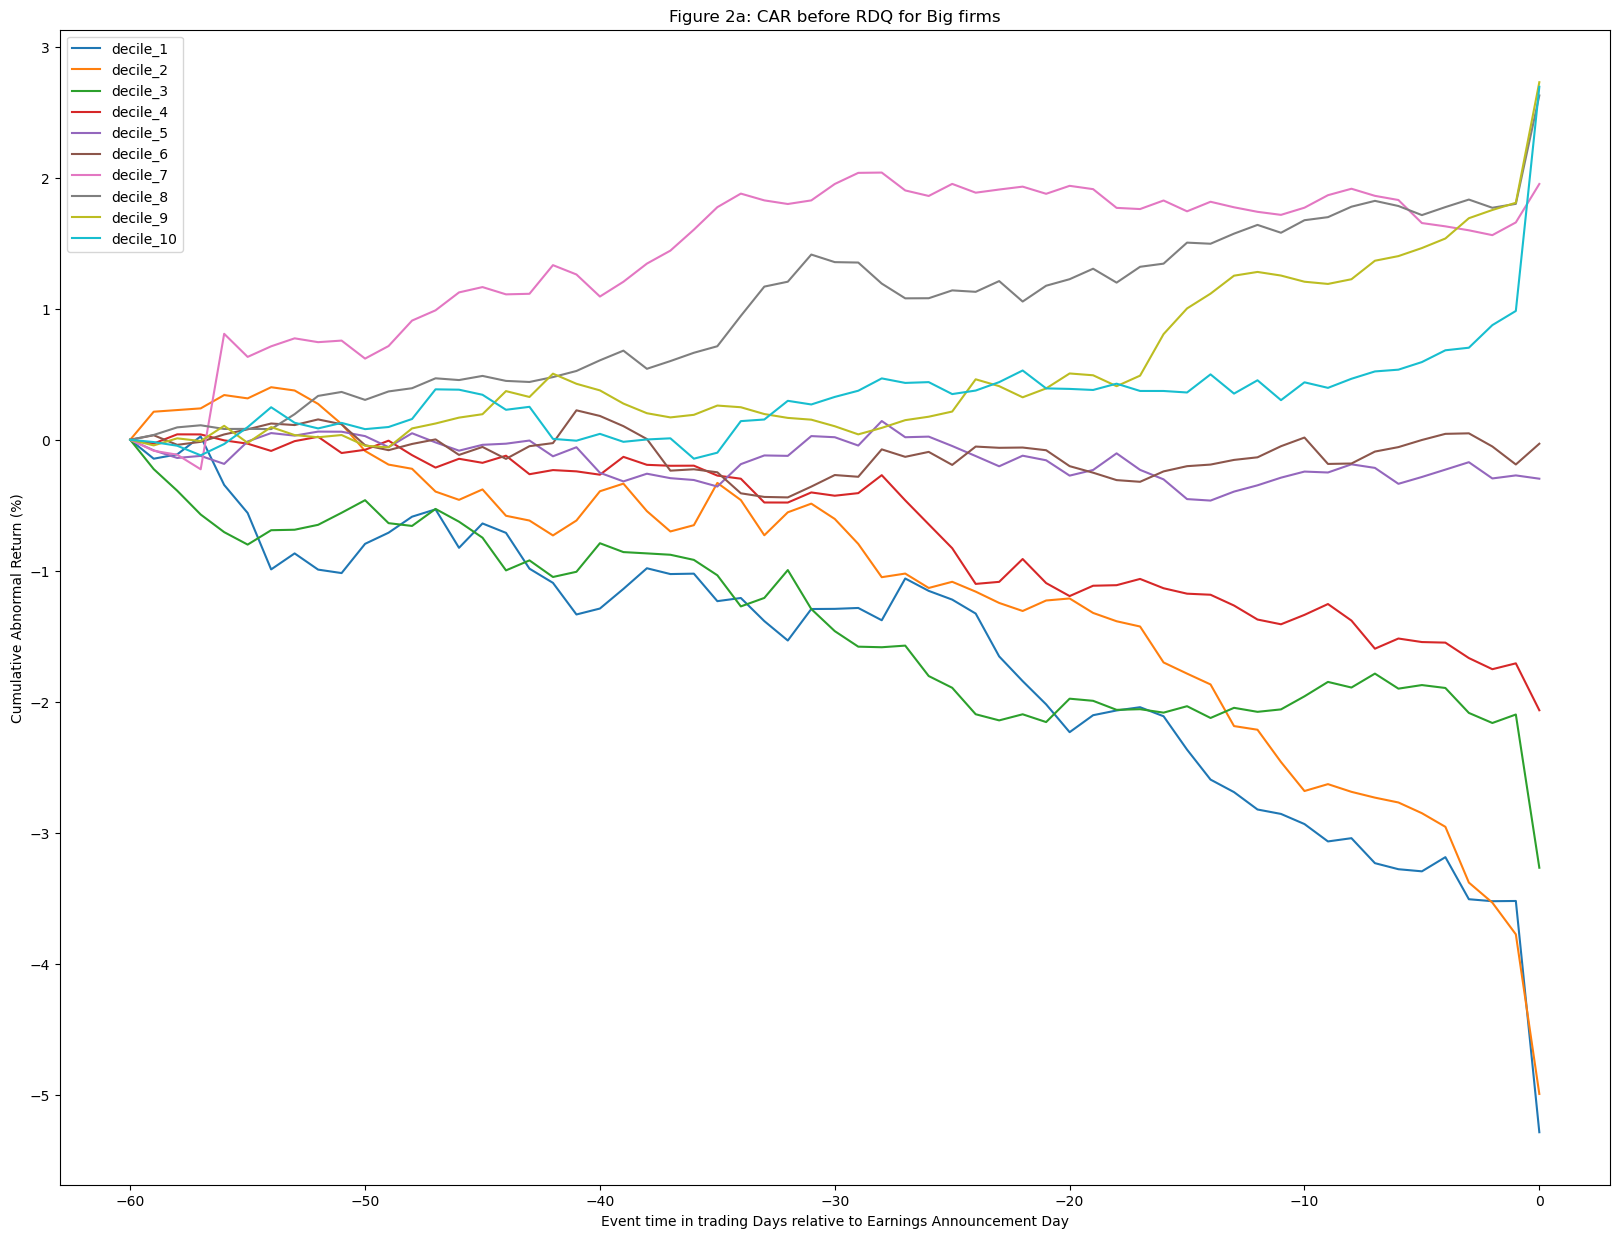

In [25]:
#new dataframe to store data
avgCARBigBefore = pd.DataFrame()
for i in range(1,11):
    avgCARBigBefore['decile_' + str(i)] = 100 * pd.DataFrame(carBigByDaysBefore[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARBigBefore = avgCARBigBefore.reset_index()
avgCARBigBefore = avgCARBigBefore.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARBigBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARBigBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARBigBefore['days_relative_to_rdq'] -= 60

#Plot graph in python
bigFirmsBeforeRDQ = avgCARBigBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR before RDQ for Big firms")
bigFirmsBeforeRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
bigFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = bigFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/bigFirmsBeforeRDQ.png")

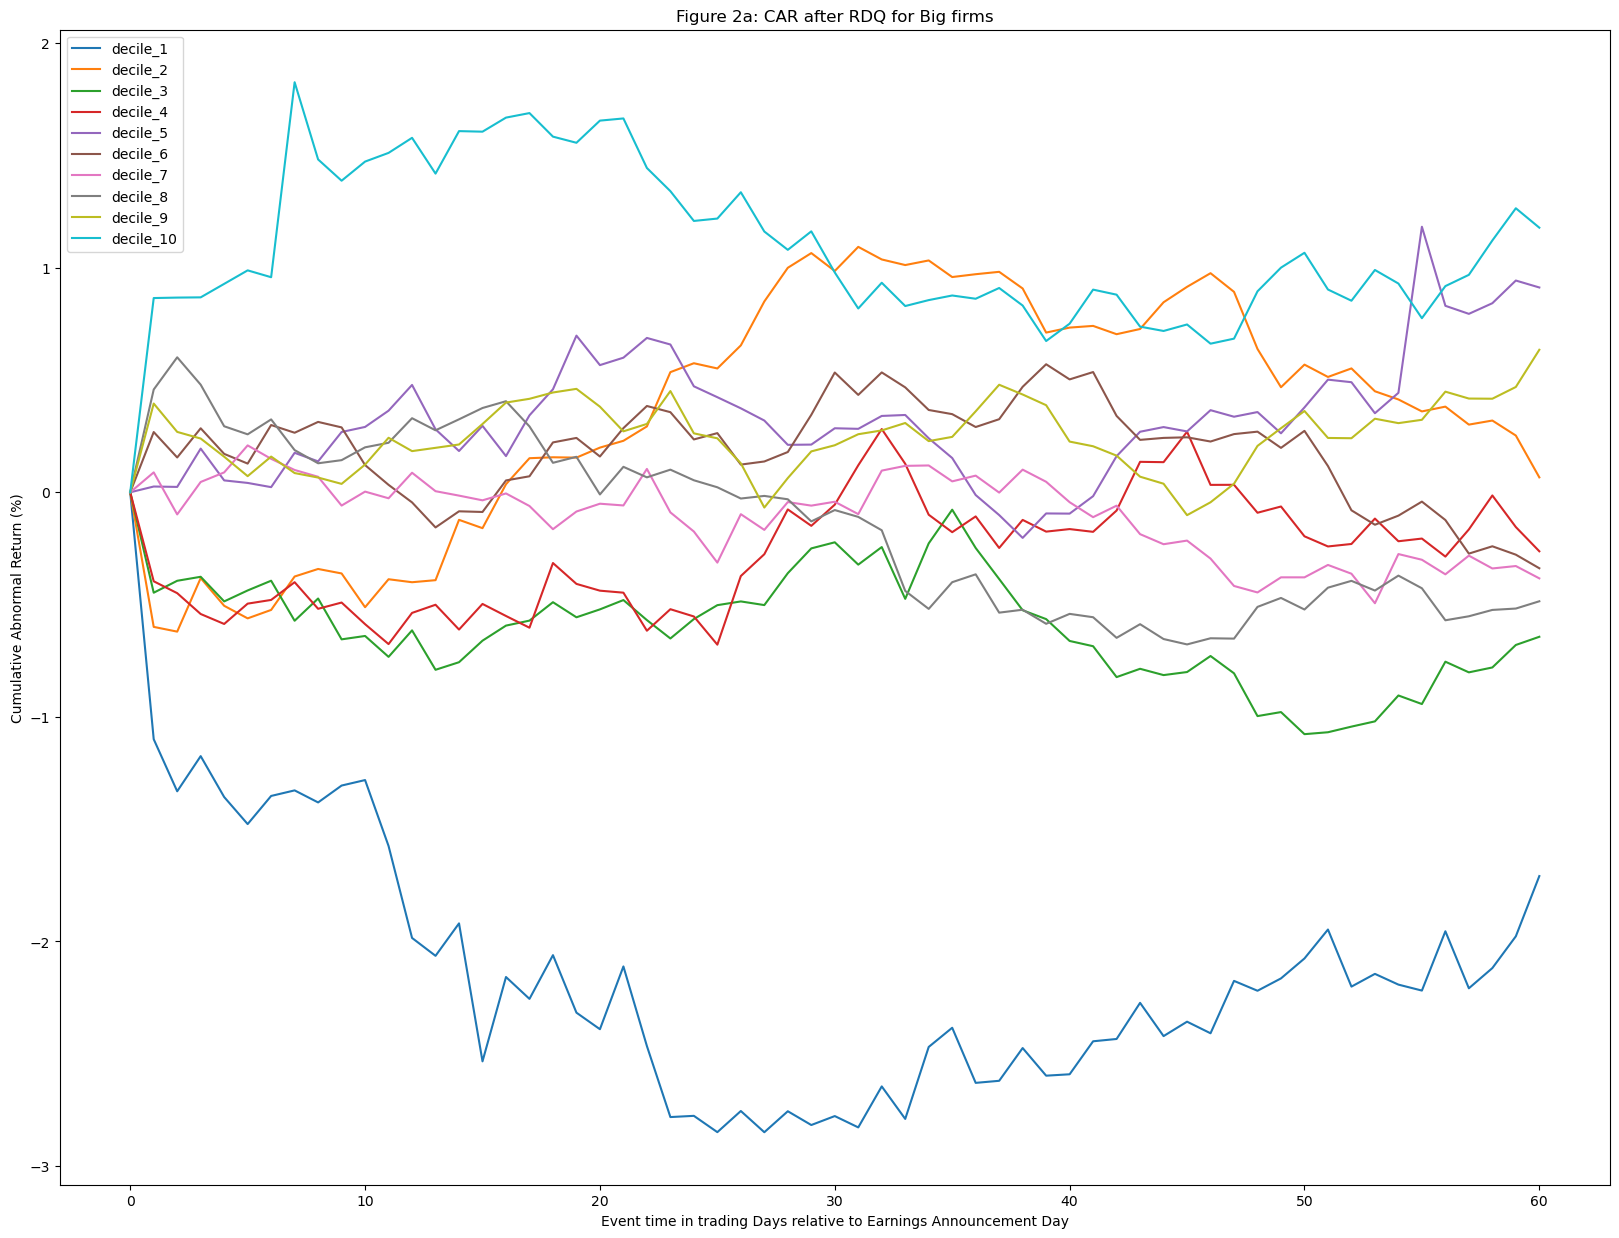

In [26]:
#new dataframe to store data
avgCARBigAfter = pd.DataFrame()
for i in range(1,11):
    avgCARBigAfter['decile_' + str(i)] = 100 * pd.DataFrame(carBigByDaysAfter[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARBigAfter = avgCARBigAfter.reset_index()
avgCARBigAfter = avgCARBigAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [0, 60] since data is before RDQ
avgCARBigAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARBigAfter['days_relative_to_rdq'], errors = 'coerce')

#Plot after graph in python
bigFirmsAfterRDQ = avgCARBigAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR after RDQ for Big firms")
bigFirmsAfterRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
bigFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = bigFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/bigFirmsAfterRDQ.png")

In [27]:
### Small firms: calcuclate CAR for every RDQ

mainDF = originalMain

#bottom 4 size deciles
mainDF = mainDF[mainDF['size_decile'] <= 4]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)

#Generate new dataframe with tic, sue decile, and size decile on rdq
TicOfRDQSmall = mainDF.dropna()
TicOfRDQSmall = TicOfRDQSmall.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetSmall = mainDF.reset_index()
abnRetSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetSmall = abnRetSmall.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetSmall['new_index'] = abnRetSmall['tic'].apply(str) + "/" + abnRetSmall['original_index'].apply(str)
abnRetSmall = abnRetSmall.set_index('new_index')

#create new array to store CAR around RDQ
carArrayBeforeSmall = []
carArrayAfterSmall = []
for i in range(11):
    carArrayBeforeSmall.append([])
    carArrayAfterSmall.append([])
    
#calculate Car and store them in corresponding SUE deciles
n = 60 #set to number of days before/after rdq to be analyzed

for rdqDate in TicOfRDQSmall.index:
    #Generate indicies for abnormal return dataframe
    nDaysBeforeIndex = str(TicOfRDQSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate - n)
    rdqDateIndex = str(TicOfRDQSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate + n)
    if (nDaysBeforeIndex in abnRetSmall.index) and (nDaysAfterIndex in abnRetSmall.index):
        #Add n days before CAR
        beforeDF = pd.DataFrame(abnRetSmall.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
        beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF.loc[0, 'abn_ret']
        carArrayBeforeSmall[TicOfRDQSmall.loc[rdqDate, 'sue_decile'].astype(int)].append(beforeDF['car'])
        #Add n days after CAR
        afterDF = pd.DataFrame(abnRetSmall.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF.loc[0, 'abn_ret']
        carArrayAfterSmall[TicOfRDQSmall.loc[rdqDate, 'sue_decile'].astype(int)].append(afterDF['car'])

In [28]:
### Small FIRMS: generate new car arrays for each decile and each day

#Create new array to store car data on each day before RDQ
carSmallByDaysBefore = []
#Set up empty array
for i in range(11):
    carSmallByDaysBefore.append([])
    for j in range(61):
        carSmallByDaysBefore[i].append([])

#Add Car data
for i in range(len(carArrayBeforeSmall)):
    for j in range(len(carArrayBeforeSmall[i])):
        for k in range(len(carSmallByDaysBefore[i])):
            carSmallByDaysBefore[i][k].append(carArrayBeforeSmall[i][j][k])
            
#Create new array to store car data on each day after RDQ
carSmallByDaysAfter = []
#Set up empty array
for i in range(11):
    carSmallByDaysAfter.append([])
    for j in range(61):
        carSmallByDaysAfter[i].append([])
        
#Add Car data
for i in range(len(carArrayAfterSmall)):
    for j in range(len(carArrayAfterSmall[i])):
        for k in range(len(carSmallByDaysAfter[i])):
            carSmallByDaysAfter[i][k].append(carArrayAfterSmall[i][j][k])

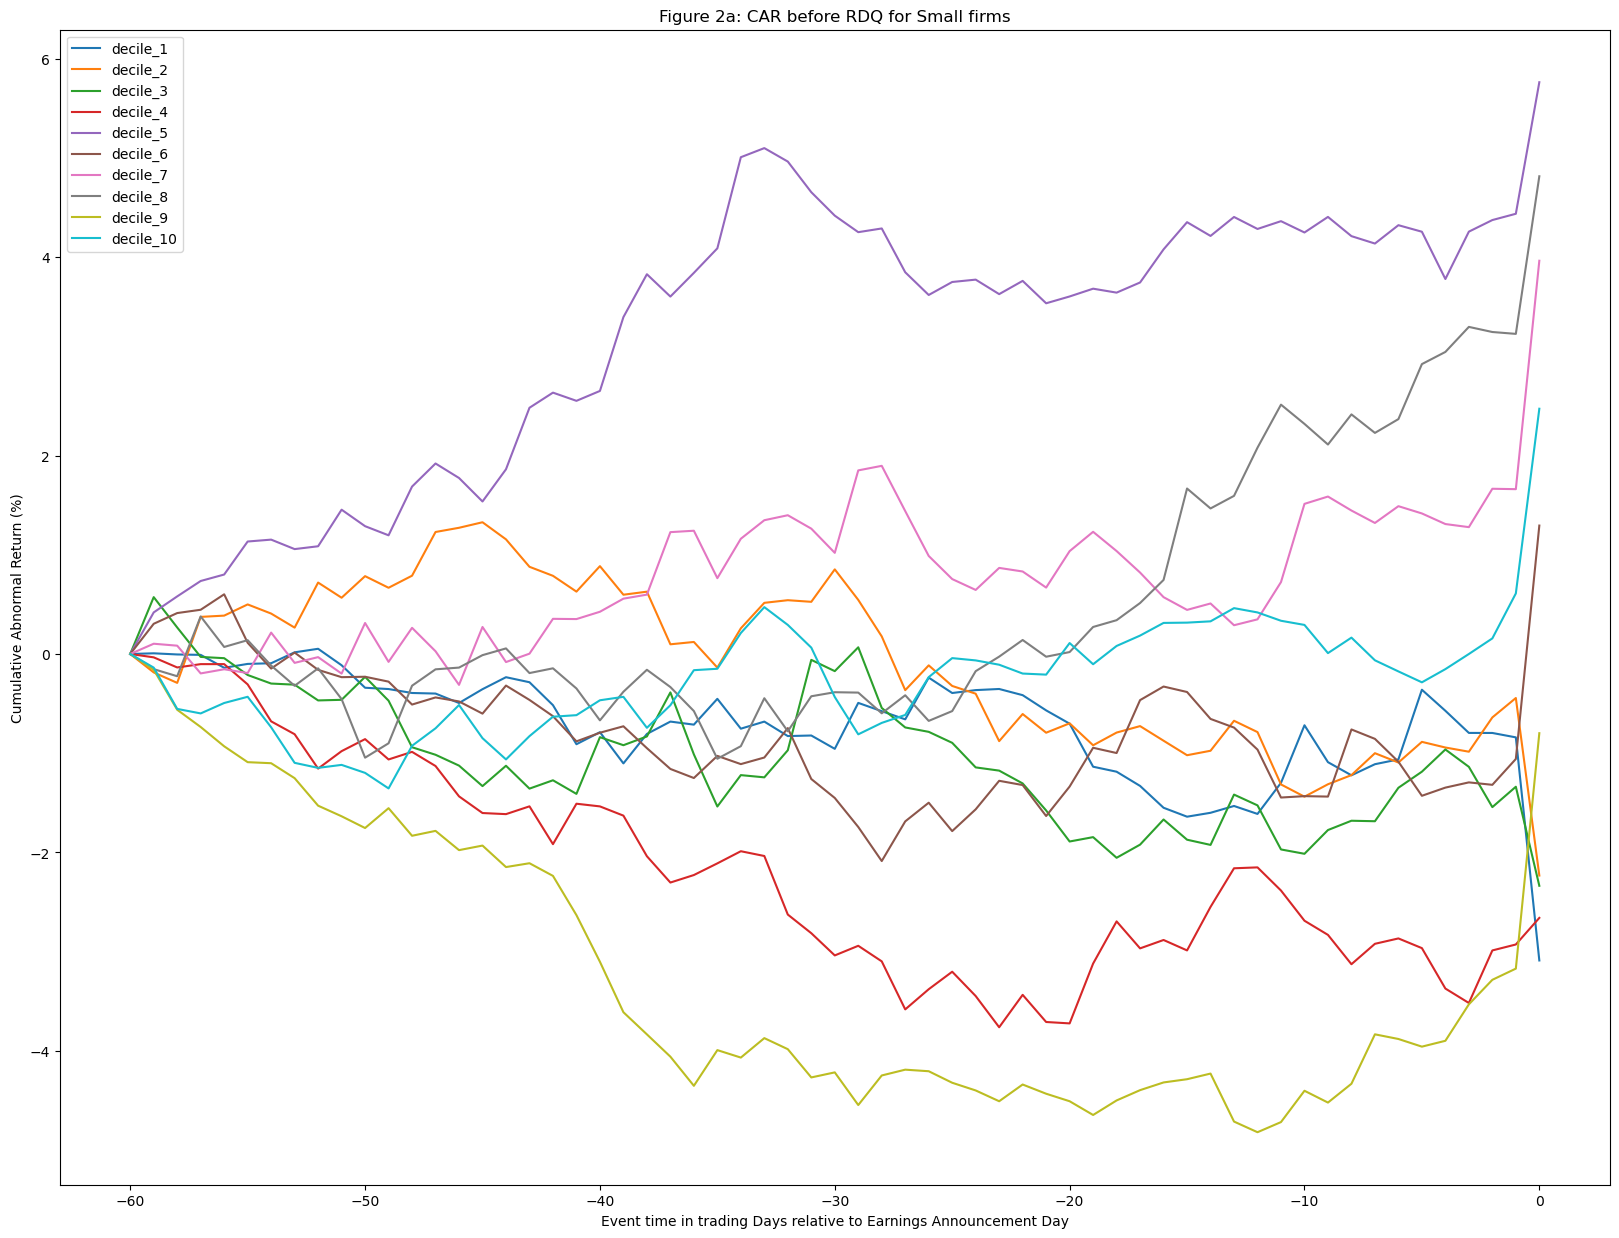

In [29]:
#new dataframe to store data
avgCARSmallBefore = pd.DataFrame()
for i in range(1,11):
    avgCARSmallBefore['decile_' + str(i)] = 100 * pd.DataFrame(carSmallByDaysBefore[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARSmallBefore = avgCARSmallBefore.reset_index()
avgCARSmallBefore = avgCARSmallBefore.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARSmallBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARSmallBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARSmallBefore['days_relative_to_rdq'] -= 60

#Plot graph in python
smallFirmsBeforeRDQ = avgCARSmallBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR before RDQ for Small firms")
smallFirmsBeforeRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
smallFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = smallFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/smallFirmsBeforeRDQ.png")

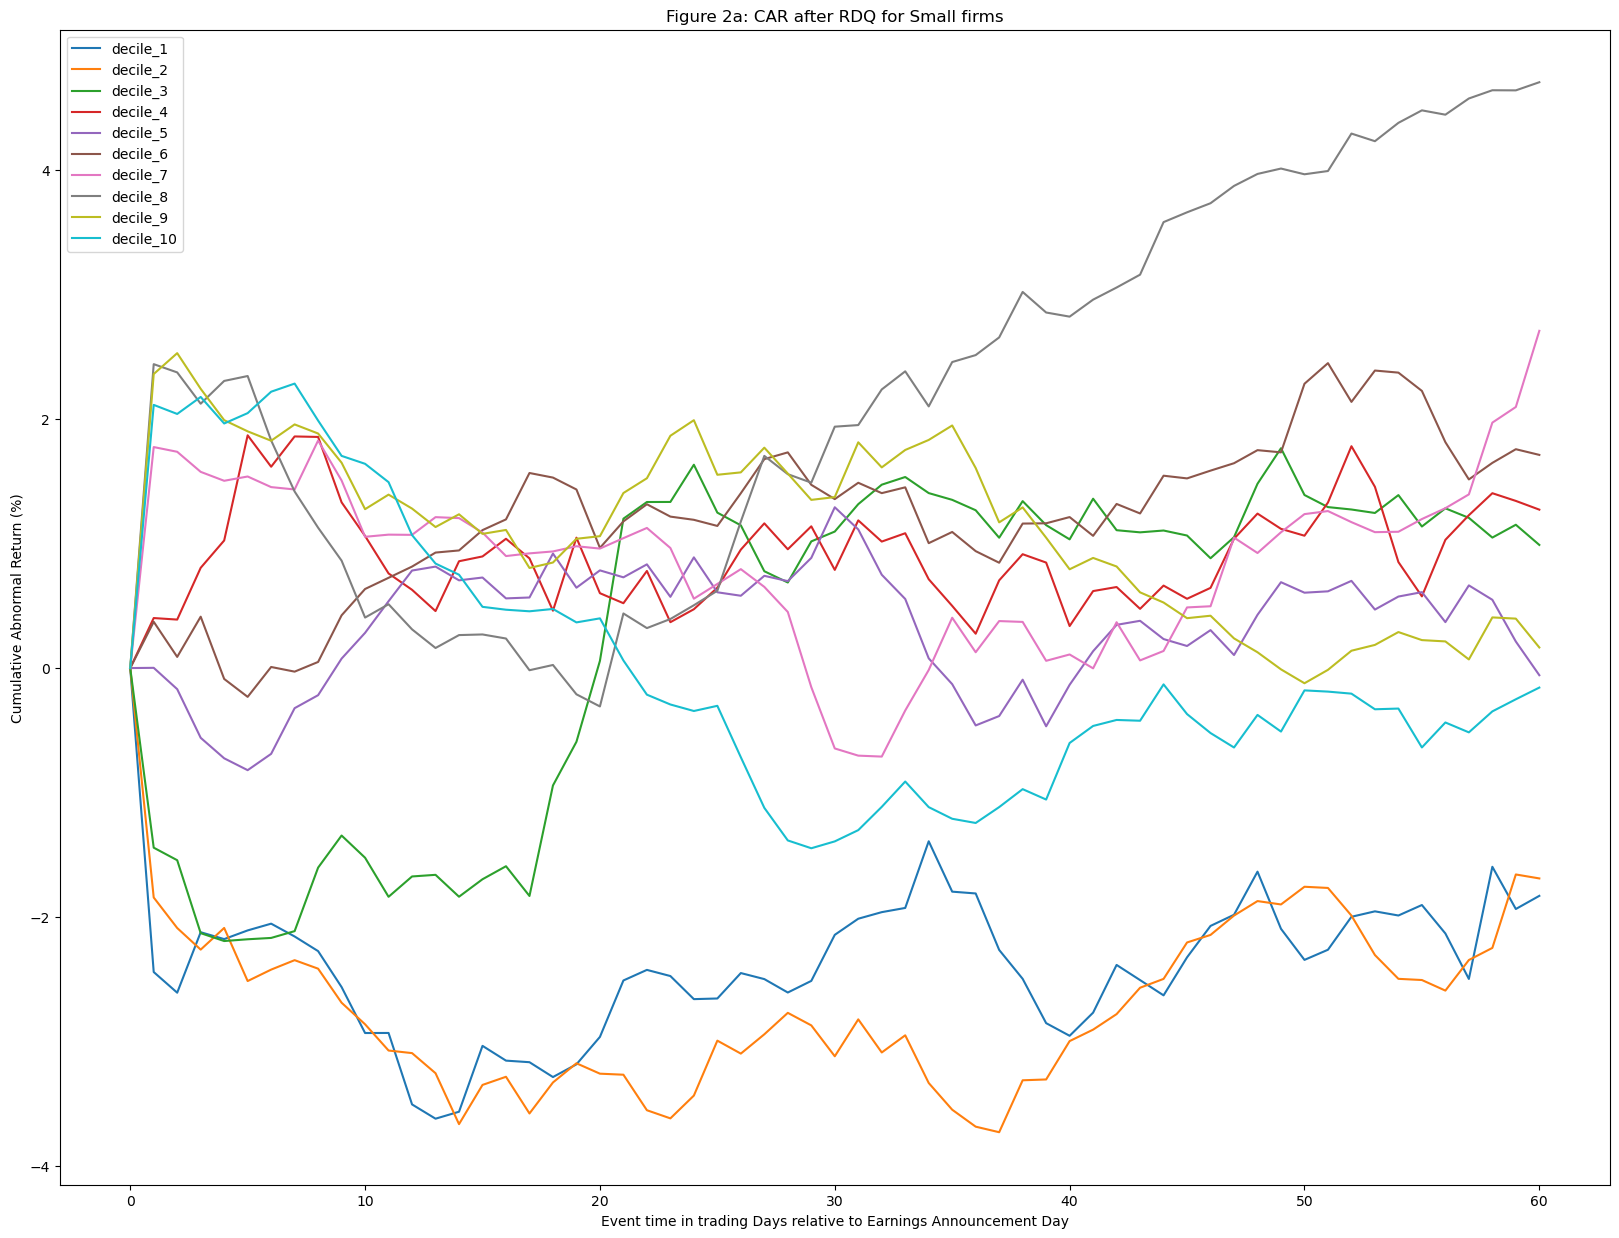

In [30]:
#new dataframe to store data
avgCARSmallAfter = pd.DataFrame()
for i in range(1,11):
    avgCARSmallAfter['decile_' + str(i)] = 100 * pd.DataFrame(carSmallByDaysAfter[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARSmallAfter = avgCARSmallAfter.reset_index()
avgCARSmallAfter = avgCARSmallAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [0, 60] since data is before RDQ
avgCARSmallAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARSmallAfter['days_relative_to_rdq'], errors = 'coerce')

#Plot after graph in python
smallFirmsAfterRDQ = avgCARSmallAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize = [20, 15], title = "Figure 2a: CAR after RDQ for Small firms")
smallFirmsAfterRDQ.set_xlabel("Event time in trading Days relative to Earnings Announcement Day")
smallFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#save graph to file
fig = smallFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/smallFirmsAfterRDQ.png")

In [31]:
### Medium Firms: calculate CAR for every RDQ

mainDF = originalMain

#bottom 4 size deciles
mainDF = mainDF[(mainDF['size_decile'] >= 5) & (mainDF['size_decile'] <= 7)]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)

#Generate new dataframe with tic, sue decile, and size decile on rdq
TicOfRDQMed = mainDF.dropna()
TicOfRDQMed = TicOfRDQMed.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetMed = mainDF.reset_index()
abnRetMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetMed = abnRetMed.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetMed['new_index'] = abnRetMed['tic'].apply(str) + "/" + abnRetMed['original_index'].apply(str)
abnRetMed = abnRetMed.set_index('new_index')

#create new array to store CAR around RDQ
carArrayBeforeMed = []
carArrayAfterMed = []
for i in range(11):
    carArrayBeforeMed.append([])
    carArrayAfterMed.append([])
    
#calculate Car and store them in corresponding SUE deciles
n = 60 #set to number of days before/after rdq to be analyzed

for rdqDate in TicOfRDQMed.index:
    #Generate indicies for abnormal return dataframe
    nDaysBeforeIndex = str(TicOfRDQMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate - n)
    rdqDateIndex = str(TicOfRDQMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate + n)
    if (nDaysBeforeIndex in abnRetMed.index) and (nDaysAfterIndex in abnRetMed.index):
        #Add n days before CAR
        beforeDF = pd.DataFrame(abnRetMed.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
        beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF.loc[0, 'abn_ret']
        carArrayBeforeMed[TicOfRDQMed.loc[rdqDate, 'sue_decile'].astype(int)].append(beforeDF['car'])
        #Add n days after CAR
        afterDF = pd.DataFrame(abnRetMed.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF.loc[0, 'abn_ret']
        carArrayAfterMed[TicOfRDQMed.loc[rdqDate, 'sue_decile'].astype(int)].append(afterDF['car'])

In [32]:
### Med FIRMS: generate new car arrays for each decile and each day

#Create new array to store car data on each day before RDQ
carMedByDaysBefore = []
#Set up empty array
for i in range(11):
    carMedByDaysBefore.append([])
    for j in range(61):
        carMedByDaysBefore[i].append([])

#Add Car data
for i in range(len(carArrayBeforeMed)):
    for j in range(len(carArrayBeforeMed[i])):
        for k in range(len(carMedByDaysBefore[i])):
            carMedByDaysBefore[i][k].append(carArrayBeforeMed[i][j][k])
            
#Create new array to store car data on each day after RDQ
carMedByDaysAfter = []
#Set up empty array
for i in range(11):
    carMedByDaysAfter.append([])
    for j in range(61):
        carMedByDaysAfter[i].append([])
        
#Add Car data
for i in range(len(carArrayAfterMed)):
    for j in range(len(carArrayAfterMed[i])):
        for k in range(len(carMedByDaysAfter[i])):
            carMedByDaysAfter[i][k].append(carArrayAfterMed[i][j][k])

In [33]:
#new dataframe to store data
avgCARMedBefore = pd.DataFrame()
for i in range(1,11):
    avgCARMedBefore['decile_' + str(i)] = 100 * pd.DataFrame(carMedByDaysBefore[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARMedBefore = avgCARMedBefore.reset_index()
avgCARMedBefore = avgCARMedBefore.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARMedBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARMedBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARMedBefore['days_relative_to_rdq'] -= 60

print(avgCARMedBefore)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60  0.000000  0.000000  0.000000  0.000000  0.000000   
1                    -59 -0.078346  0.112226  0.080097 -0.004700  0.110307   
2                    -58 -0.194874 -0.063677  0.006422 -0.017229  0.352583   
3                    -57 -0.371369 -0.247666  0.105164 -0.038270  0.356514   
4                    -56 -0.502690 -0.182769  0.199854  0.007071  0.435816   
..                   ...       ...       ...       ...       ...       ...   
56                    -4 -1.878975 -1.700613 -3.112488 -0.647457 -0.602407   
57                    -3 -2.030990 -1.798270 -3.360889 -0.773434 -0.582562   
58                    -2 -1.952682 -1.771198 -3.745184 -0.863559 -0.459544   
59                    -1 -1.791847 -1.950511 -3.574596 -0.972310 -0.163017   
60                     0 -3.568990 -2.655062 -4.939300 -1.076006  0.229451   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

In [34]:
#new dataframe to store data
avgCARMedAfter = pd.DataFrame()
for i in range(1,11):
    avgCARMedAfter['decile_' + str(i)] = 100 * pd.DataFrame(carMedByDaysAfter[i]).mean(axis = 1)
    
#Add column to store days relative to RDQ
avgCARMedAfter = avgCARMedAfter.reset_index()
avgCARMedAfter = avgCARMedAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [0, 60] since data is before RDQ
avgCARMedAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARMedAfter['days_relative_to_rdq'], errors = 'coerce')

print(avgCARMedAfter)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.480706 -1.767391 -1.010070  0.123688  0.263485   
2                      2 -2.117054 -1.622753 -1.322838  0.040073  0.297633   
3                      3 -2.380571 -1.537951 -1.305959 -0.024345  0.292560   
4                      4 -2.179580 -1.692320 -1.389651 -0.186215  0.184557   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -1.761847 -0.823453 -0.628415  0.107297 -0.426801   
57                    57 -1.826926 -0.712730 -0.449620  0.304056 -0.224183   
58                    58 -1.617520 -0.825706 -0.595497  0.405357 -0.112891   
59                    59 -1.504563 -0.831913 -0.633759  0.363321  0.087124   
60                    60 -1.404203 -0.428079 -0.907966  0.250571  0.187780   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

In [35]:
### Generate CAR Data for every 60d period unday day 480 ###

periodLength = 15
periodStartsToAnalyze = [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#Big Firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQBigHiLo = TicOfRDQBig[(TicOfRDQBig['sue_decile'] == 1) | (TicOfRDQBig['sue_decile'] == 10)]
carDaysAfterRDQBig = pd.DataFrame(index = periodStartsToAnalyze, columns = [1, 10])
for i in carDaysAfterRDQBig.index:
    for j in carDaysAfterRDQBig.columns:
        carDaysAfterRDQBig[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQBig.index:
    for rdqDate in TicOfRDQBigHiLo.index:
        #generate indices for abnormal return dataframe
        mDaysAfterRDQStartIndex = str(TicOfRDQBigHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
        mDaysAfterRDQEndIndex = str(TicOfRDQBigHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
        if (mDaysAfterRDQStartIndex in abnRetBig.index) and (mDaysAfterRDQEndIndex in abnRetBig.index):
            periodDF = pd.DataFrame(abnRetBig.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
            periodDF['car'] = periodDF['abn_ret'].cumsum()
            carDaysAfterRDQBig[TicOfRDQBigHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])
            
#Take averages of each array to get Car on final day
for i in carDaysAfterRDQBig.index:
    for j in carDaysAfterRDQBig.columns:
        carDaysAfterRDQBig[j][i] = np.average(carDaysAfterRDQBig[j][i]) * 100

In [36]:
#Med Firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQMedHiLo = TicOfRDQMed[(TicOfRDQMed['sue_decile'] == 1) | (TicOfRDQMed['sue_decile'] == 10)]
carDaysAfterRDQMed = pd.DataFrame(index = periodStartsToAnalyze, columns = [1, 10])
for i in carDaysAfterRDQMed.index:
    for j in carDaysAfterRDQMed.columns:
        carDaysAfterRDQMed[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQMed.index:
    for rdqDate in TicOfRDQMedHiLo.index:
        #generate indices for abnormal return dataframe
        mDaysAfterRDQStartIndex = str(TicOfRDQMedHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
        mDaysAfterRDQEndIndex = str(TicOfRDQMedHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
        if (mDaysAfterRDQStartIndex in abnRetMed.index) and (mDaysAfterRDQEndIndex in abnRetMed.index):
            periodDF = pd.DataFrame(abnRetMed.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
            periodDF['car'] = periodDF['abn_ret'].cumsum()
            carDaysAfterRDQMed[TicOfRDQMedHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])
            
#Take averages of each array to get Car on final day
for i in carDaysAfterRDQMed.index:
    for j in carDaysAfterRDQMed.columns:
        carDaysAfterRDQMed[j][i] = np.average(carDaysAfterRDQMed[j][i]) * 100

In [37]:
#Small Firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQSmallHiLo = TicOfRDQSmall[(TicOfRDQSmall['sue_decile'] == 1) | (TicOfRDQSmall['sue_decile'] == 10)]
carDaysAfterRDQSmall = pd.DataFrame(index = periodStartsToAnalyze, columns = [1, 10])
for i in carDaysAfterRDQSmall.index:
    for j in carDaysAfterRDQSmall.columns:
        carDaysAfterRDQSmall[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQSmall.index:
    for rdqDate in TicOfRDQSmallHiLo.index:
        #generate indices for abnormal return dataframe
        mDaysAfterRDQStartIndex = str(TicOfRDQSmallHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
        mDaysAfterRDQEndIndex = str(TicOfRDQSmallHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
        if (mDaysAfterRDQStartIndex in abnRetSmall.index) and (mDaysAfterRDQEndIndex in abnRetSmall.index):
            periodDF = pd.DataFrame(abnRetSmall.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
            periodDF['car'] = periodDF['abn_ret'].cumsum()
            carDaysAfterRDQSmall[TicOfRDQSmallHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])
            
#Take averages of each array to get Car on final day
for i in carDaysAfterRDQSmall.index:
    for j in carDaysAfterRDQSmall.columns:
        carDaysAfterRDQSmall[j][i] = np.average(carDaysAfterRDQSmall[j][i]) * 100

In [38]:
### Replicate table 1
table1A = pd.DataFrame(index = range(9))
table1A["holding_period"] = ["-59 to -45", "-44 to -30", "-29 to -15", "-14 to 0", "1 to 15", "16 to 30", "31 to 45", "46 to 60", "61 to 75"]
for i in ["s", "m", "b"]:
    for j in ["h", "l", "diff"]:
        table1A[(i + "/" + j)] = ""

#Small/high sue firms
for i in range (0, 9):
    table1A['s/h'][i] = carDaysAfterRDQSmall[10][(i - 4) * 15 + 1]
    
#Small/low sue firms
for i in range (0, 9):
    table1A['s/l'][i] = carDaysAfterRDQSmall[1][(i - 4) * 15 + 1]
    
#Small/diff
table1A['s/diff'] = table1A['s/h'] - table1A['s/l']

#Medium/high sue firms
for i in range (0, 9):
    table1A['m/h'][i] = carDaysAfterRDQMed[10][(i - 4) * 15 + 1]
    
#Medium/low sue firms
for i in range (0, 9):
    table1A['m/l'][i] = carDaysAfterRDQMed[1][(i - 4) * 15 + 1]
    
#Medium/diff
table1A['m/diff'] = table1A['m/h'] - table1A['m/l']

#Big/high sue firms
for i in range (0, 9):
    table1A['b/h'][i] = carDaysAfterRDQBig[10][(i - 4) * 15 + 1]
    
#Big/low sue firms
for i in range (0, 9):
    table1A['b/l'][i] = carDaysAfterRDQBig[1][(i - 4) * 15 + 1]
    
#Big/diff
table1A['b/diff'] = table1A['b/h'] - table1A['b/l']

print(table1A)

  holding_period       s/h       s/l    s/diff       m/h       m/l    m/diff  \
0     -59 to -45 -0.447643 -0.326684 -0.120959  0.530018  0.166849  0.363169   
1     -44 to -30  0.560625 -0.337573  0.898198 -0.329445  -0.36732  0.037875   
2     -29 to -15  0.903951 -0.643487  1.547438  0.940446 -1.521046  2.461491   
3       -14 to 0  1.810127 -1.381979  3.192106  2.352414 -2.535077  4.887491   
4        1 to 15   0.71384 -2.911994  3.625834  1.353244  -1.36544  2.718685   
5       16 to 30 -1.973199  0.522005 -2.495204 -0.902828  0.533433  -1.43626   
6       31 to 45   0.81779 -0.150897  0.968686  0.522359 -0.515376  1.037735   
7       46 to 60  0.403567  0.392457   0.01111  0.159798  0.232261 -0.072463   
8       61 to 75 -1.109249 -0.135122 -0.974127  0.044191 -0.876499   0.92069   

        b/h       b/l    b/diff  
0  0.296756 -0.895484   1.19224  
1 -0.155153  -0.91164  0.756487  
2 -0.154541 -0.800539  0.645998  
3  2.319221 -2.442754  4.761975  
4  1.263034 -2.522747  3.7857

In [39]:
table1B = pd.DataFrame(index = range(5))
table1B['holding_period'] = ["1 to 15", "1 to 30", "1 to 45", "1 to 60", "1 to 75"]
for i in ["s", "m", "b"]:
    table1B[i + "/diff"] = ""
    table1B[i + "/diff_as_fraction_of_75d_drift"] = ""
    
for i in ['s/diff', 'm/diff', 'b/diff']:
    table1B[i][0] = table1A[i][4]
    table1B[i][1] = table1B[i][0] + table1A[i][5]
    table1B[i][2] = table1B[i][1] + table1A[i][6]
    table1B[i][3] = table1B[i][2] + table1A[i][7]
    table1B[i][4] = table1B[i][3] + table1A[i][8]
    
table1B['s/diff_as_fraction_of_75d_drift'] = table1B['s/diff'] / table1B['s/diff'][4]
table1B['m/diff_as_fraction_of_75d_drift'] = table1B['m/diff'] / table1B['m/diff'][4]
table1B['b/diff_as_fraction_of_75d_drift'] = table1B['b/diff'] / table1B['b/diff'][4]

print(table1B)

  holding_period    s/diff s/diff_as_fraction_of_75d_drift    m/diff  \
0        1 to 15  3.625834                        3.190913  2.718685   
1        1 to 30   1.13063                         0.99501  1.282424   
2        1 to 45  2.099316                        1.847502  2.320159   
3        1 to 60  2.110427                        1.857279  2.247696   
4        1 to 75    1.1363                             1.0  3.168386   

  m/diff_as_fraction_of_75d_drift    b/diff b/diff_as_fraction_of_75d_drift  
0                        0.858066  3.785781                        2.457423  
1                        0.404756  3.554598                        2.307357  
2                        0.732284  3.012357                        1.955378  
3                        0.709414  3.284213                        2.131845  
4                             1.0   1.54055                             1.0  


In [40]:
### Extreme GN/BN firms: Generate 30-day Cumulative Abnormal Returns with Different method including date of data for Table 3
mainDF = originalMain
mainDFHiLo = mainDF[(mainDF['sue_decile'] == 1) | (mainDF['sue_decile'] == 10)]

#Generate new dataframe with tic, sue decile, and size decile on RDQ
TicOfRDQHiLo = mainDFHiLo.dropna()
TicOfRDQHiLo = TicOfRDQHiLo.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetHiLo = mainDFHiLo.reset_index()
abnRetHiLo.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetHiLo = abnRetHiLo.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetHiLo['new_index'] = abnRetHiLo['tic'].apply(str) + "/" + abnRetHiLo['original_index'].apply(str)
abnRetHiLo = abnRetHiLo.set_index('new_index')

#Create new dataframes to store Car around RDQ
car30dHiLoWithDates = mainDF.filter(['tic', 'date', 'sue_decile'])
car30dHiLoWithDates['days_after_rdq'] = ""
car30dHiLoWithDates['car'] = ""

car60dHiLoWithDates = mainDF.filter(['tic', 'date', 'sue_decile'])
car60dHiLoWithDates['days_after_rdq'] = ""
car60dHiLoWithDates['car'] = ""

In [41]:
# Calculate CAR and store them in corresponding SUE Deciles
n = 30  # set to number of days before/after RDQ to be analyzed

for rdqDate in TicOfRDQHiLo.index:
    # Generate indices for abnormal return dataframe
    rdqDateIndex = str(TicOfRDQHiLo.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQHiLo.loc[rdqDate, 'tic']) + "/" + str(rdqDate + n)
    if nDaysAfterIndex in abnRetHiLo.index:
        # Add n days after CAR
        afterDF = pd.DataFrame(abnRetHiLo.loc[rdqDateIndex:nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]  # calculate CAR (sum of all abn_ret - first abn_ret)

        car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
        car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']

m = 60 #set to number of days before/after RDQ to be analyzed
for rdqDate in TicOfRDQHiLo.index:
    # Generate indices for abnormal return dataframe
    rdqDateIndex = str(TicOfRDQHiLo.loc[rdqDate, 'tic']) + "/" + str(rdqDate)
    nDaysAfterIndex = str(TicOfRDQHiLo.loc[rdqDate, 'tic']) + "/" + str(rdqDate + m)
    if nDaysAfterIndex in abnRetHiLo.index:
        # Add n days after CAR
        afterDF = pd.DataFrame(abnRetHiLo.loc[rdqDateIndex:nDaysAfterIndex]).reset_index()
        afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]  # calculate CAR (sum of all abn_ret - first abn_ret)

        car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
        car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
    
car30dHiLoWithDates['car'] *= 100
car30dHiLoWithDates = car30dHiLoWithDates[car30dHiLoWithDates['days_after_rdq'] == 30]

car60dHiLoWithDates['car'] *= 100
car60dHiLoWithDates = car60dHiLoWithDates[car60dHiLoWithDates['days_after_rdq'] == 60]

print(car30dHiLoWithDates)
print(car60dHiLoWithDates)


C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + n + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate : rdqDate + m + 1] = afterDF.index
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
C:\Users\aaron\AppData\Local\Temp\ipykernel_18960\160172968.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

         tic       date  sue_decile days_after_rdq        car
2993     AAN 2021-06-09        10.0             30  -0.291878
3383     AAP 2019-09-25         1.0             30  10.847086
3512     AAP 2020-03-31        10.0             30   -2.91405
3763     AAP 2021-03-30         1.0             30  16.421177
5268     ABC 2020-09-17        10.0             30  -7.865754
...      ...        ...         ...            ...        ...
1104424  ZEN 2021-03-19         1.0             30 -24.311748
1104545  ZEN 2021-09-10         1.0             30 -24.827107
1106125  ZTS 2021-06-18        10.0             30  11.016325
1106711  ZUO 2020-07-16        10.0             30 -11.063857
1106775  ZUO 2020-10-15        10.0             30 -34.280234

[2020 rows x 5 columns]
          tic       date  sue_decile days_after_rdq         car
9532      ACA 2021-05-20        10.0             60  -10.787171
17473     ADT 2021-02-03         1.0             60    3.360601
17596     ADT 2021-07-30         1.0   

In [42]:
### Replicate table 3 ###

#Import fama french data
file = filePath + '/F-F_Research_Data_5_Factors_Daily.csv'
ffDF = pd.read_csv(file)

#Convert variables
ffDF['Date'] = pd.to_datetime(ffDF['Date'], format = '%Y%m%d')
ffDF['Mkt-RF'] = pd.to_numeric(ffDF['Mkt-RF'], errors = 'coerce')
ffDF['SMB'] = pd.to_numeric(ffDF['SMB'], errors = 'coerce')
ffDF['HML'] = pd.to_numeric(ffDF['HML'], errors = 'coerce')
ffDF['RMW'] = pd.to_numeric(ffDF['RMW'], errors = 'coerce')
ffDF['CMA'] = pd.to_numeric(ffDF['CMA'], errors = 'coerce')
ffDF['RF'] = pd.to_numeric(ffDF['RF'], errors = 'coerce')

#Add MKT column (not adjusted for treasury bills)
ffDF['mkt'] = ffDF['Mkt-RF'] + ffDF['RF']

#Rename columns
ffDF.columns = ['date', 'rm_minus_rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'mkt']

#Only keep data after 2019
ffDF = ffDF[ffDF['date'] >= "2019-01-01"]

#Left join ff into car30dHiLoWithDates
ffDF.to_sql("ffDF", conn, if_exists = 'replace')
car30dHiLoWithDates.to_sql("car30dHiLoWithDates", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT car30dHiLoWithDates.*, ffDF.rm_minus_rf, ffDF.smb, ffDF.hml, ffDF.rmw, ffDF.cma, ffDF.rf, ffDF.mkt
        FROM car30dHiLoWithDates
        LEFT JOIN ffDF
        ON car30dHiLoWithDates.date = ffDF.date
        '''

car30dHiLoWithFF = pd.read_sql(query, conn)

#Generate table 3
table3A = sm.ols("car ~ rm_minus_rf + smb + hml + rmw + cma", data = car30dHiLoWithFF).fit()
table3ASummary = table3A.summary()
table3B = sm.ols("car ~ smb + hml + rmw + cma + mkt", data = car30dHiLoWithFF).fit()
table3BSummary = table3B.summary()

print(table3ASummary)
print(table3BSummary)

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.267
Date:                Mon, 31 Jul 2023   Prob (F-statistic):              0.275
Time:                        23:49:47   Log-Likelihood:                -8714.8
No. Observations:                2020   AIC:                         1.744e+04
Df Residuals:                    2014   BIC:                         1.748e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0651      0.410     -2.598      

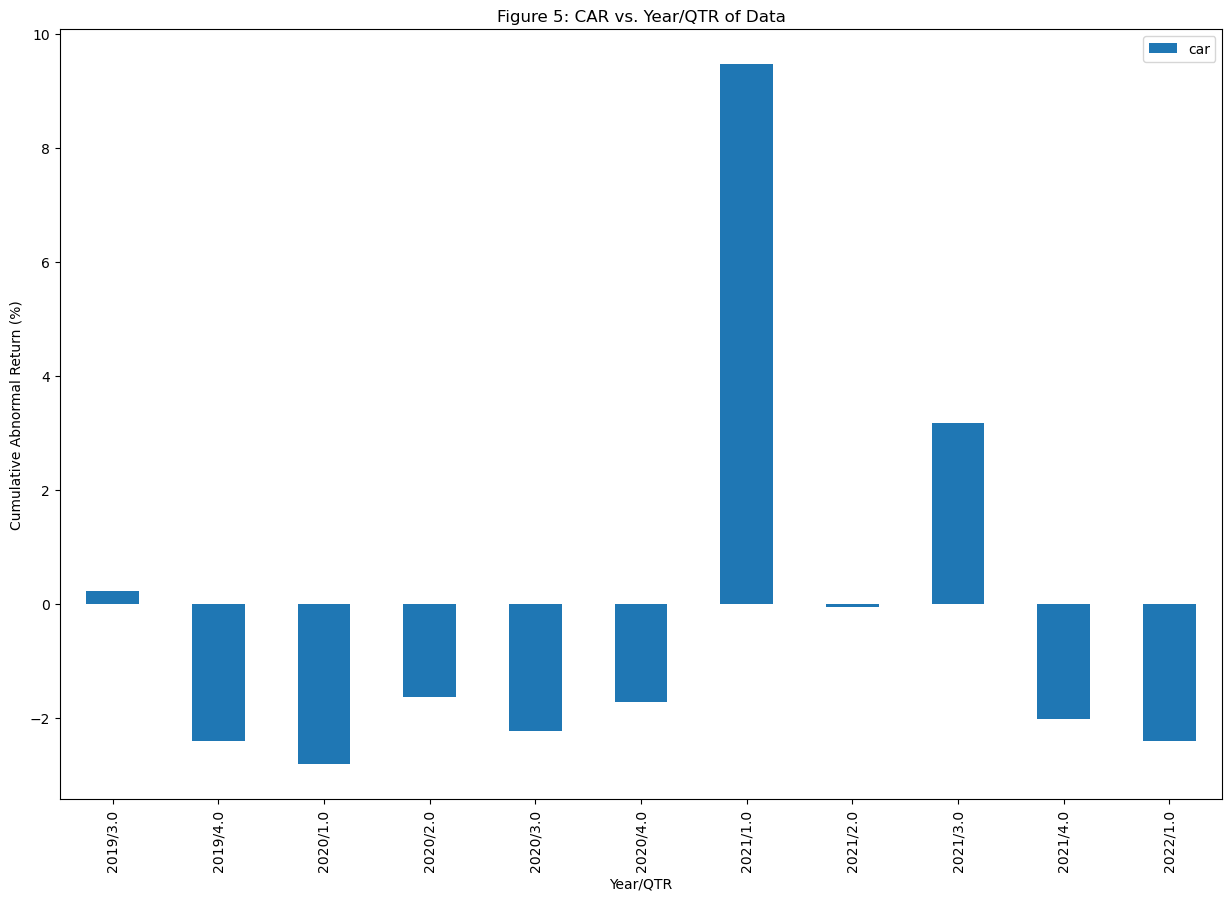

In [43]:
### Replicate Figure 5 ###
car60dHiLoWithDates['year'] = car60dHiLoWithDates['date'].dt.year
car60dHiLoWithDates['qtr'] = np.ceil(car60dHiLoWithDates['date'].dt.month / 3)
car60dHiLoWithDates['year/qtr'] = car60dHiLoWithDates['year'].apply(str) + "/" + car60dHiLoWithDates['qtr'].apply(str)

car60dHiLoWithDates = car60dHiLoWithDates[car60dHiLoWithDates['days_after_rdq'] == 60]
car60dGroupedByYearQtr = car60dHiLoWithDates.groupby('year/qtr', as_index = False)['car'].mean()

plotCAR60dByYearQtr = car60dGroupedByYearQtr.plot(x = 'year/qtr', y = ['car'], kind = "bar", figsize = [15, 10], title = "Figure 5: CAR vs. Year/QTR of Data")
plotCAR60dByYearQtr.set_xlabel("Year/QTR")
plotCAR60dByYearQtr.set_ylabel("Cumulative Abnormal Return (%)")

fig = plotCAR60dByYearQtr.get_figure()
fig.savefig(filePath + "/plotCAR60dByYearQTR.png")

In [44]:
### Generate dataframes for each portfolio agaain for raw returns instead of CAR ###

#Generate mainDf's for each portfolio
mainDF = originalMain
mainDFLo = mainDF[mainDF['sue_decile'] == 1]
mainDFLoSmall = mainDFLo[mainDFLo['size_decile'] <= 4]
mainDFLoMed = mainDFLo[(mainDFLo['size_decile'] >= 5) & (mainDFLo['size_decile'] <= 7)]
mainDFLoBig = mainDFLo[mainDFLo['size_decile'] >= 8]
mainDFHi = mainDF[mainDF['sue_decile'] == 10]
mainDFHiSmall = mainDFHi[mainDFHi['size_decile'] <= 4]
mainDFHiMed = mainDFHi[(mainDFHi['size_decile'] >= 5) & (mainDFHi['size_decile'] <= 7)]
mainDFHiBig = mainDFHi[mainDFHi['size_decile'] >= 8]

#Generate TicOfRDQ and raw return dataframes for each portfolio
#S/L
ticOfRDQLoSmall = mainDFLoSmall.dropna()
ticOfRDQLoSmall = ticOfRDQLoSmall.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoSmall = mainDF.reset_index()
rawRetLoSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetLoSmall = rawRetLoSmall.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetLoSmall['new_index'] = rawRetLoSmall['tic'].apply(str) + "/" + rawRetLoSmall['original_index'].apply(str)
rawRetLoSmall = rawRetLoSmall.set_index('new_index')

In [45]:
#M/L
ticOfRDQLoMed = mainDFLoMed.dropna()
ticOfRDQLoMed = ticOfRDQLoMed.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoMed = mainDF.reset_index()
rawRetLoMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetLoMed = rawRetLoMed.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetLoMed['new_index'] = rawRetLoMed['tic'].apply(str) + "/" + rawRetLoMed['original_index'].apply(str)
rawRetLoMed = rawRetLoMed.set_index('new_index')

In [46]:
#B/L
ticOfRDQLoBig = mainDFLoBig.dropna()
ticOfRDQLoBig = ticOfRDQLoBig.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoBig = mainDF.reset_index()
rawRetLoBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetLoBig = rawRetLoBig.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetLoBig['new_index'] = rawRetLoBig['tic'].apply(str) + "/" + rawRetLoBig['original_index'].apply(str)
rawRetLoBig = rawRetLoBig.set_index('new_index')

In [47]:
#S/H
ticOfRDQHiSmall = mainDFHiSmall.dropna()
ticOfRDQHiSmall = ticOfRDQHiSmall.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiSmall = mainDF.reset_index()
rawRetHiSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetHiSmall = rawRetHiSmall.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetHiSmall['new_index'] = rawRetHiSmall['tic'].apply(str) + "/" + rawRetHiSmall['original_index'].apply(str)
rawRetHiSmall = rawRetHiSmall.set_index('new_index')

In [48]:
#M/H
ticOfRDQHiMed = mainDFHiMed.dropna()
ticOfRDQHiMed = ticOfRDQHiMed.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiMed = mainDF.reset_index()
rawRetHiMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetHiMed = rawRetHiMed.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetHiMed['new_index'] = rawRetHiMed['tic'].apply(str) + "/" + rawRetHiMed['original_index'].apply(str)
rawRetHiMed = rawRetHiMed.set_index('new_index')

In [49]:
#B/H
ticOfRDQHiBig = mainDFHiBig.dropna()
ticOfRDQHiBig = ticOfRDQHiBig.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiBig = mainDF.reset_index()
rawRetHiBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decille']
rawRetHiBig = rawRetHiBig.groupby(['tic', 'original_index'], as_index = False)['ret'].first()
rawRetHiBig['new_index'] = rawRetHiBig['tic'].apply(str) + "/" + rawRetHiBig['original_index'].apply(str)
rawRetHiBig = rawRetHiBig.set_index('new_index')

In [50]:
#Starting and ending days of periods to calculate raw returns
startingDays = [1, 6, 21, 41, 61]
endingDays = [5, 20, 40, 60, 80]

#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRLoSmall = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoSmall.index:
    for j in avgCRRLoSmall.columns:
        avgCRRLoSmall[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQLoSmall.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQLoSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQLoSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetLoSmall.index) and (endIndex in rawRetLoSmall.index):
            periodDF = pd.DataFrame(rawRetLoSmall.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRLoSmall['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRLoSmall.index:
    avgCRRLoSmall.loc[i, 'crr'] = np.average(avgCRRLoSmall.loc[i, 'crr']) * 100

In [51]:
#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRLoMed = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoMed.index:
    for j in avgCRRLoMed.columns:
        avgCRRLoMed[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQLoMed.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQLoMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQLoMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetLoMed.index) and (endIndex in rawRetLoMed.index):
            periodDF = pd.DataFrame(rawRetLoMed.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRLoMed['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRLoMed.index:
    avgCRRLoMed.loc[i, 'crr'] = np.average(avgCRRLoMed.loc[i, 'crr']) * 100

In [52]:
#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRLoBig = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoBig.index:
    for j in avgCRRLoBig.columns:
        avgCRRLoBig[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQLoBig.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQLoBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQLoBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetLoBig.index) and (endIndex in rawRetLoBig.index):
            periodDF = pd.DataFrame(rawRetLoBig.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRLoBig['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRLoBig.index:
    avgCRRLoBig.loc[i, 'crr'] = np.average(avgCRRLoBig.loc[i, 'crr']) * 100

In [53]:
#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRHiSmall = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiSmall.index:
    for j in avgCRRHiSmall.columns:
        avgCRRHiSmall[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQHiSmall.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQHiSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQHiSmall.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetHiSmall.index) and (endIndex in rawRetHiSmall.index):
            periodDF = pd.DataFrame(rawRetHiSmall.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRHiSmall['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRHiSmall.index:
    avgCRRHiSmall.loc[i, 'crr'] = np.average(avgCRRHiSmall.loc[i, 'crr']) * 100

In [54]:
#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRHiMed = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiMed.index:
    for j in avgCRRHiMed.columns:
        avgCRRHiMed[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQHiMed.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQHiMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQHiMed.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetHiMed.index) and (endIndex in rawRetHiMed.index):
            periodDF = pd.DataFrame(rawRetHiMed.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRHiMed['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRHiMed.index:
    avgCRRHiMed.loc[i, 'crr'] = np.average(avgCRRHiMed.loc[i, 'crr']) * 100

In [55]:
#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRHiBig = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiBig.index:
    for j in avgCRRHiBig.columns:
        avgCRRHiBig[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
    a = startingDays[i]
    b = endingDays[i]
    for rdqDate in ticOfRDQHiBig.index:
        #Generate indices for raw return dataframe
        startIndex = str(ticOfRDQHiBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate + a)
        endIndex = str(ticOfRDQHiBig.loc[rdqDate, 'tic']) + "/" + str(rdqDate + b)
        if (startIndex in rawRetHiBig.index) and (endIndex in rawRetHiBig.index):
            periodDF = pd.DataFrame(rawRetHiBig.loc[startIndex : endIndex]).reset_index()
            periodDF['crr'] = periodDF['ret'].cumsum()
            avgCRRHiBig['crr'][a].append(periodDF['crr'][b-a])
            
#Take averages of each aray to get average CRR on final day
for i in avgCRRHiBig.index:
    avgCRRHiBig.loc[i, 'crr'] = np.average(avgCRRHiBig.loc[i, 'crr']) * 100

In [56]:
print(avgCRRLoSmall)
print(avgCRRLoMed)
print(avgCRRLoBig)
print(avgCRRHiSmall)
print(avgCRRHiMed)
print(avgCRRHiBig)

         crr
1  -1.769781
6   1.274562
21  2.839626
41  4.965631
61  0.493371
         crr
1  -2.210137
6   3.102147
21  0.516394
41  2.376906
61  0.450262
         crr
1  -1.003209
6  -0.605426
21   1.27234
41  2.513633
61  2.168169
         crr
1   3.158258
6   1.071449
21  0.862913
41  4.394104
61  3.995017
         crr
1   1.389746
6   1.048385
21  0.495416
41  3.593268
61   3.65969
         crr
1   1.544914
6   1.150487
21 -0.557461
41  3.561169
61  1.973681


In [57]:
### Replicate table 4 ###

table4A = pd.DataFrame(index = startingDays)
table4A['postannouncement_period'] = ["(1, 5)", "(6, 20)", "(21, 40)", "(41, 60)", "(61, 80)"]
table4A['s/l_rr'] = avgCRRLoSmall['crr']
table4A['s/l_crr'] = table4A['s/l_rr'].cumsum()
table4A['m/l_rr'] = avgCRRLoMed['crr']
table4A['m/l_crr'] = table4A['m/l_rr'].cumsum()
table4A['b/l_rr'] = avgCRRLoBig['crr']
table4A['b/l_crr'] = table4A['b/l_rr'].cumsum()

print(table4A)

   postannouncement_period    s/l_rr   s/l_crr    m/l_rr   m/l_crr    b/l_rr  \
1                   (1, 5) -1.769781 -1.769781 -2.210137 -2.210137 -1.003209   
6                  (6, 20)  1.274562 -0.495219  3.102147  0.892009 -0.605426   
21                (21, 40)  2.839626  2.344407  0.516394  1.408403   1.27234   
41                (41, 60)  4.965631  7.310038  2.376906  3.785309  2.513633   
61                (61, 80)  0.493371  7.803409  0.450262  4.235571  2.168169   

     b/l_crr  
1  -1.003209  
6  -1.608635  
21 -0.336295  
41  2.177339  
61  4.345508  


In [58]:
table4B = pd.DataFrame(index = startingDays)
table4B['postannouncement_period'] = ["(1, 5)", "(1, 20)", "(1, 40)", "(1, 60)", "(1, 80)"]

table4B['s/l_crr_annualized'] = ""
for i in range(0, 5, 1):
    table4B['s/l_crr_annualized'][startingDays[i]] = table4A['s/l_crr'][startingDays[i]] * 252 / endingDays[i]
    
table4B['m/l_crr_annualized'] = ""
for i in range(0, 5, 1):
    table4B['m/l_crr_annualized'][startingDays[i]] = table4A['m/l_crr'][startingDays[i]] * 252 / endingDays[i]

table4B['b/l_crr_annualized'] = ""
for i in range(0, 5, 1):
    table4B['b/l_crr_annualized'][startingDays[i]] = table4A['b/l_crr'][startingDays[i]] * 252 / endingDays[i]
    
table4B['s/h_crr_annualized'] = ""
table4B['s/h_crr_annualized'] = avgCRRHiSmall.cumsum()
for i in range(0, 5, 1):
    table4B['s/h_crr_annualized'][startingDays[i]] *= 252 / endingDays[i]
    
table4B['m/h_crr_annualized'] = ""
table4B['m/h_crr_annualized'] = avgCRRHiMed.cumsum()
for i in range(0, 5, 1):
    table4B['m/h_crr_annualized'][startingDays[i]] *= 252 / endingDays[i]
    
table4B['b/h_crr_annualized'] = ""
table4B['b/h_crr_annualized'] = avgCRRHiBig.cumsum()
for i in range(0, 5, 1):
    table4B['b/h_crr_annualized'][startingDays[i]] *= 252 / endingDays[i]
    
table4B['low_avg'] = table4B.iloc[:, 1:4].mean(axis = 1)
table4B['high_avg'] = table4B.iloc[:, 4:7].mean(axis = 1)

In [59]:
print(table4B)

   postannouncement_period s/l_crr_annualized m/l_crr_annualized  \
1                   (1, 5)         -89.196966        -111.390924   
6                  (1, 20)          -6.239754          11.239315   
21                 (1, 40)          14.769767           8.872942   
41                 (1, 60)          30.702161          15.898298   
61                 (1, 80)          24.580738           13.34205   

   b/l_crr_annualized s/h_crr_annualized m/h_crr_annualized  \
1          -50.561745         159.176191          70.043181   
6          -20.268798          53.294301          30.720447   
21          -2.118658          32.083503          18.481344   
41           9.144822          39.844239          27.412623   
61           13.68835          42.467485          32.087491   

   b/h_crr_annualized    low_avg    high_avg  
1           77.863675 -83.716545  102.361015  
6           33.962049  -5.089746   39.325599  
21          13.469018   7.174684   21.344622  
41          23.936257  1

In [60]:
### Replicate table 2 ###
mainDF = originalMain

### add treasury bills (r_f) and equity risk (r_m - r_f) to mainDF
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
ffDF.to_sql("ffDF", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, ffDF.rm_minus_rf, ffDF.rf
        FROM mainDF
        LEFT JOIN ffDF
        ON mainDF.date = ffDF.date
        '''
mainDF = pd.read_sql(query, conn)

#Convert ff data to decimal
mainDF['rm_minus_rf'] /= 100
mainDF['rf'] /= 100
mainDF.drop('index', inplace = True, axis = 1)

#Create starting days and ending days arrays
startingDays2 = [-119, -59, 1, 61, 121, 181]
endingDays2 = [-60, 0, 60, 120, 180, 240]

In [61]:
def calculateCumRawRetCompounded(startingDay, endingDay, ticsToAnalyze):
    cumRetMinusCumRF = []
    cumRMMinusRF = []
    for i in ticsToAnalyze.index:
        #Generate indices for abnormal return dataframe
        startIndex = i + startingDay
        endIndex = i + endingDay
        if((startIndex in mainDF.index) and (mainDF.loc[startIndex, 'tic'] == ticsToAnalyze.loc[i, 'tic']) and (endIndex in mainDF.index) and (mainDF.loc[endIndex, 'tic'] == ticsToAnalyze.loc[i, 'tic'])):
            retWindowDF = pd.DataFrame(mainDF.loc[startIndex : endIndex]).reset_index()
            retWindowDF['cum_ret'] = (1 + retWindowDF['ret']).cumprod() - 1
            retWindowDF['cum_rm_minus_rf'] = (1 + retWindowDF['rm_minus_rf']).cumprod() - 1
            retWindowDF['cum_rf'] = (1 + retWindowDF['rf']).cumprod() - 1
            cumRetMinusCumRF.append(retWindowDF.loc[endingDay - startingDay, 'cum_ret'] - retWindowDF.loc[endingDay - startingDay, 'cum_rf'])
            cumRMMinusRF.append(retWindowDF.loc[endingDay - startingDay, 'cum_rm_minus_rf'])
    resultsDF = pd.DataFrame()
    resultsDF['cum_ret_minus_cum_rf'] = cumRetMinusCumRF
    resultsDF['cum_rm_minus_rf'] = cumRMMinusRF
    return resultsDF

In [62]:
#Run regressions for each decile on each period
for j in range(1, 11):
    currentTicsToAnalyze = TicOfRDQ[TicOfRDQ['sue_decile'] == j]
    for k in range(len(startingDays2)):
        dfForTable2Reg = calculateCumRawRetCompounded(startingDays2[k], endingDays2[k], currentTicsToAnalyze)
        tempReg = sm.ols("cum_ret_minus_cum_rf ~ cum_rm_minus_rf", data = dfForTable2Reg).fit()
        tempRegSummary = tempReg.summary()
        print("Decile = " + str(j) + "; starting day of period " + str(startingDays2[k]) + ":")
        print(tempRegSummary)

Decile = 1; starting day of period -119:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.094
Model:                              OLS   Adj. R-squared:                  0.093
Method:                   Least Squares   F-statistic:                     125.2
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           1.00e-27
Time:                          23:50:40   Log-Likelihood:                -671.48
No. Observations:                  1213   AIC:                             1347.
Df Residuals:                      1211   BIC:                             1357.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Decile = 1; starting day of period 181:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.160
Model:                              OLS   Adj. R-squared:                  0.159
Method:                   Least Squares   F-statistic:                     138.1
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           2.60e-29
Time:                          23:50:54   Log-Likelihood:                -199.95
No. Observations:                   725   AIC:                             403.9
Df Residuals:                       723   BIC:                             413.1
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Decile = 2; starting day of period 121:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.184
Model:                              OLS   Adj. R-squared:                  0.183
Method:                   Least Squares   F-statistic:                     164.5
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           4.33e-34
Time:                          23:51:09   Log-Likelihood:                -488.62
No. Observations:                   730   AIC:                             981.2
Df Residuals:                       728   BIC:                             990.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Decile = 3; starting day of period 61:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.121
Model:                              OLS   Adj. R-squared:                  0.120
Method:                   Least Squares   F-statistic:                     127.6
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           8.10e-28
Time:                          23:51:24   Log-Likelihood:                -492.66
No. Observations:                   927   AIC:                             989.3
Df Residuals:                       925   BIC:                             999.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Decile = 4; starting day of period 1:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.240
Model:                              OLS   Adj. R-squared:                  0.239
Method:                   Least Squares   F-statistic:                     326.9
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           1.01e-63
Time:                          23:51:39   Log-Likelihood:                -95.413
No. Observations:                  1039   AIC:                             194.8
Df Residuals:                      1037   BIC:                             204.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

Decile = 5; starting day of period -59:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.193
Model:                              OLS   Adj. R-squared:                  0.192
Method:                   Least Squares   F-statistic:                     277.7
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           4.53e-56
Time:                          23:51:53   Log-Likelihood:                -36.954
No. Observations:                  1165   AIC:                             77.91
Df Residuals:                      1163   BIC:                             88.03
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Decile = 6; starting day of period -119:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.220
Model:                              OLS   Adj. R-squared:                  0.219
Method:                   Least Squares   F-statistic:                     305.4
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           1.98e-60
Time:                          23:52:07   Log-Likelihood:                -2.8694
No. Observations:                  1084   AIC:                             9.739
Df Residuals:                      1082   BIC:                             19.72
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Decile = 6; starting day of period 181:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.121
Model:                              OLS   Adj. R-squared:                  0.120
Method:                   Least Squares   F-statistic:                     95.58
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           3.07e-21
Time:                          23:52:22   Log-Likelihood:                -13.624
No. Observations:                   697   AIC:                             31.25
Df Residuals:                       695   BIC:                             40.34
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Decile = 7; starting day of period 121:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.342
Model:                              OLS   Adj. R-squared:                  0.341
Method:                   Least Squares   F-statistic:                     429.7
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           3.41e-77
Time:                          23:52:37   Log-Likelihood:                 57.676
No. Observations:                   829   AIC:                            -111.4
Df Residuals:                       827   BIC:                            -101.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Decile = 8; starting day of period 61:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.278
Model:                              OLS   Adj. R-squared:                  0.277
Method:                   Least Squares   F-statistic:                     366.3
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           2.50e-69
Time:                          23:52:51   Log-Likelihood:                 96.097
No. Observations:                   954   AIC:                            -188.2
Df Residuals:                       952   BIC:                            -178.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

Decile = 9; starting day of period 1:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.217
Model:                              OLS   Adj. R-squared:                  0.216
Method:                   Least Squares   F-statistic:                     298.2
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           3.47e-59
Time:                          23:53:07   Log-Likelihood:                 94.165
No. Observations:                  1080   AIC:                            -184.3
Df Residuals:                      1078   BIC:                            -174.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

Decile = 10; starting day of period -59:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.235
Model:                              OLS   Adj. R-squared:                  0.234
Method:                   Least Squares   F-statistic:                     373.1
Date:                  Mon, 31 Jul 2023   Prob (F-statistic):           1.07e-72
Time:                          23:53:22   Log-Likelihood:                 98.703
No. Observations:                  1216   AIC:                            -193.4
Df Residuals:                      1214   BIC:                            -183.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------